## Input parameters

In [1]:
import nglview
import ipywidgets
import os
import zipfile
import sys

pdbCode = "pdl1"
ligandCode = "nctrl"
mol_charge = 0

/home/nikka/miniconda3/envs/biobb/lib/python3.12/site-packages/nglview/__init__.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# importing protein and ligand pdb from file
# Only import and use cat_pdb since your files are already separated.
from biobb_structure_utils.utils.cat_pdb import cat_pdb

# Use paths to your actual files; update these variable names as needed
proteinFile = "PD-L1.pdb"   # e.g., 'yourprotein.pdb'
ligandFile = "pd-l1_Losartan_CID_3961.pdb"     # e.g., 'yourligand.pdb'
complexFile = "CTLA4_nctrl.pdb"   # Name for output complex file

# Concatenate to create the complex PDB file
cat_pdb(
    input_structure1=proteinFile,
    input_structure2=ligandFile,
    output_structure_path=complexFile
)

print(proteinFile, ligandFile, complexFile)


2025-10-17 19:02:49,673 [MainThread  ] [INFO ]  Module: biobb_structure_utils.utils.cat_pdb Version: 5.1.0
2025-10-17 19:02:49,673 [MainThread  ] [INFO ]  /home/nikka/GMX_via_biobb/sandbox_b08c62e6-7642-4632-8078-a52796cba951 directory successfully created
2025-10-17 19:02:49,674 [MainThread  ] [INFO ]  Copy: /home/nikka/GMX_via_biobb/PD-L1.pdb to /home/nikka/GMX_via_biobb/sandbox_b08c62e6-7642-4632-8078-a52796cba951
2025-10-17 19:02:49,674 [MainThread  ] [INFO ]  Copy: /home/nikka/GMX_via_biobb/pd-l1_Losartan_CID_3961.pdb to /home/nikka/GMX_via_biobb/sandbox_b08c62e6-7642-4632-8078-a52796cba951
2025-10-17 19:02:49,675 [MainThread  ] [INFO ]  Removed: ['/home/nikka/GMX_via_biobb/sandbox_b08c62e6-7642-4632-8078-a52796cba951']
2025-10-17 19:02:49,676 [MainThread  ] [INFO ]  
PD-L1.pdb pd-l1_Losartan_CID_3961.pdb CTLA4_nctrl.pdb


In [3]:
# visualize generated 3D structures
# Show structures: protein, ligand and protein-ligand complex
view1 = nglview.show_structure_file(proteinFile)
view1._remote_call('setSize', target='Widget', args=['350px','400px'])
view1.camera='orthographic'
view1
view2 = nglview.show_structure_file(ligandFile)
view2.add_representation(repr_type='ball+stick')
view2._remote_call('setSize', target='Widget', args=['350px','400px'])
view2.camera='orthographic'
view2
view3 = nglview.show_structure_file(complexFile)
view3.add_representation(repr_type='licorice', radius='.5', selection=ligandCode)
view3._remote_call('setSize', target='Widget', args=['350px','400px'])
view3.camera='orthographic'
view3
ipywidgets.HBox([view1, view2, view3])

<a id="fix"></a>
***
## Fix protein structure
**Checking** and **fixing** (if needed) the protein structure:<br>
- **Modeling** **missing side-chain atoms**, modifying incorrect **amide assignments**, choosing **alternative locations**.<br>
- **Checking** for missing **backbone atoms**, **heteroatoms**, **modified residues** and possible **atomic clashes**.

***
**Building Blocks** used:
 - [FixSideChain](https://biobb-model.readthedocs.io/en/latest/model.html#module-model.fix_side_chain) from **biobb_model.model.fix_side_chain**
***

In [4]:
# Check & Fix Protein Structure
# Import module
from biobb_model.model.fix_side_chain import fix_side_chain

# Create prop dict and inputs/outputs
fixed_pdb = pdbCode+'_fixed.pdb'

# Create and launch bb
fix_side_chain(input_pdb_path=proteinFile,
             output_pdb_path=fixed_pdb)

2025-10-17 19:03:08,891 [MainThread  ] [INFO ]  Module: biobb_model.model.fix_side_chain Version: 5.1.0
2025-10-17 19:03:08,892 [MainThread  ] [INFO ]  /home/nikka/GMX_via_biobb/sandbox_8cf40028-0e70-4c74-a0ce-0525240d49d2 directory successfully created
2025-10-17 19:03:08,892 [MainThread  ] [INFO ]  Copy: PD-L1.pdb to /home/nikka/GMX_via_biobb/sandbox_8cf40028-0e70-4c74-a0ce-0525240d49d2
2025-10-17 19:03:08,893 [MainThread  ] [INFO ]  check_structure -i /home/nikka/GMX_via_biobb/sandbox_8cf40028-0e70-4c74-a0ce-0525240d49d2/PD-L1.pdb -o /home/nikka/GMX_via_biobb/sandbox_8cf40028-0e70-4c74-a0ce-0525240d49d2/pdl1_fixed.pdb --force_save fixside --fix ALL

2025-10-17 19:03:09,140 [MainThread  ] [INFO ]  Executing: check_structure -i /home/nikka/GMX_via_biobb/sandbox_8cf40028-0e70-4c74-a0ce-052...
2025-10-17 19:03:09,140 [MainThread  ] [INFO ]  Exit code: 0
2025-10-17 19:03:09,141 [MainThread  ] [INFO ]  ================================================================================
=     

0

<a id="top"></a>
***
## Create protein system topology
**Building GROMACS topology** corresponding to the protein structure.<br>
Force field used in this tutorial is [**amber99sb-ildn**](https://dx.doi.org/10.1002%2Fprot.22711): AMBER **parm99** force field with **corrections on backbone** (sb) and **side-chain torsion potentials** (ildn). Water molecules type used in this tutorial is [**spc/e**](https://pubs.acs.org/doi/abs/10.1021/j100308a038).<br>
Adding **hydrogen atoms** if missing. Automatically identifying **disulfide bridges**. <br>

Generating two output files: 
- **GROMACS structure** (gro file)
- **GROMACS topology** ZIP compressed file containing:
    - *GROMACS topology top file* (top file)
    - *GROMACS position restraint file/s* (itp file/s)
***
**Building Blocks** used:
 - [Pdb2gmx](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.pdb2gmx) from **biobb_gromacs.gromacs.pdb2gmx**
***

In [18]:
# Create Protein system topology
# Import module
from biobb_gromacs.gromacs.pdb2gmx import pdb2gmx

# Create inputs/outputs
output_pdb2gmx_gro = pdbCode+'_pdb2gmx.gro'
output_pdb2gmx_top_zip = pdbCode+'_pdb2gmx_top.zip'
prop = {
    'force_field' : 'amber99sb-ildn',
    'water_type': 'spce',
    'ignh': True 
}

# Create and launch bb
pdb2gmx(input_pdb_path=fixed_pdb,
        output_gro_path=output_pdb2gmx_gro,
        output_top_zip_path=output_pdb2gmx_top_zip,
        properties=prop)

2025-10-17 19:21:40,954 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.pdb2gmx Version: 5.1.0
2025-10-17 19:21:40,955 [MainThread  ] [INFO ]  /home/nikka/GMX_via_biobb/sandbox_ffd7ee9a-d87c-4594-94fc-cb7289d0328f directory successfully created
2025-10-17 19:21:40,955 [MainThread  ] [INFO ]  Copy: pdl1_fixed.pdb to /home/nikka/GMX_via_biobb/sandbox_ffd7ee9a-d87c-4594-94fc-cb7289d0328f
2025-10-17 19:21:40,956 [MainThread  ] [INFO ]  gmx -nobackup -nocopyright pdb2gmx -f /home/nikka/GMX_via_biobb/sandbox_ffd7ee9a-d87c-4594-94fc-cb7289d0328f/pdl1_fixed.pdb -o /home/nikka/GMX_via_biobb/sandbox_ffd7ee9a-d87c-4594-94fc-cb7289d0328f/pdl1_pdb2gmx.gro -p p2g.top -water spce -ff amber99sb-ildn -i posre.itp -ignh

2025-10-17 19:21:41,004 [MainThread  ] [INFO ]  Executing: gmx -nobackup -nocopyright pdb2gmx -f /home/nikka/GMX_via_biobb/sandbox_ffd7ee9a...
2025-10-17 19:21:41,004 [MainThread  ] [INFO ]  Exit code: 0
2025-10-17 19:21:41,004 [MainThread  ] [INFO ]  Using the Amber99sb-ildn forc

0

<a id="ligtop"></a>
***
## Create ligand system topology
**Building GROMACS topology** corresponding to the ligand structure.<br>
Force field used in this tutorial step is **amberGAFF**: [General AMBER Force Field](http://ambermd.org/antechamber/gaff.html), designed for rational drug design.<br>
- [Step 1](#ligandTopologyStep1): Add **hydrogen atoms** if missing.
- [Step 2](#ligandTopologyStep2): **Energetically minimize the system** with the new hydrogen atoms. 
- [Step 3](#ligandTopologyStep3): Generate **ligand topology** (parameters). 
***
**Building Blocks** used:
 - [ReduceAddHydrogens](https://biobb-chemistry.readthedocs.io/en/latest/ambertools.html#module-ambertools.reduce_add_hydrogens) from **biobb_chemistry.ambertools.reduce_add_hydrogens**
 - [BabelMinimize](https://biobb-chemistry.readthedocs.io/en/latest/babelm.html#module-babelm.babel_minimize) from **biobb_chemistry.babelm.babel_minimize** 
 - [AcpypeParamsGMX](https://biobb-chemistry.readthedocs.io/en/latest/acpype.html#module-acpype.acpype_params_gmx) from **biobb_chemistry.acpype.acpype_params_gmx** 
***

<a id="ligandTopologyStep1"></a>
### Step 1: Add **hydrogen atoms**

In [10]:
# Create Ligand system topology, STEP 1
# Reduce_add_hydrogens: add Hydrogen atoms to a small molecule (using Reduce tool from Ambertools package)
# Import module
from biobb_chemistry.ambertools.reduce_add_hydrogens import reduce_add_hydrogens

# Create prop dict and inputs/outputs
output_reduce_h = ligandCode+'.reduce.H.pdb' 
prop = {
    'nuclear' : 'true'
}

# Create and launch bb, change input and output files if necessary
reduce_add_hydrogens(input_path=ligandFile,
                   output_path=output_reduce_h,
                   properties=prop)


2025-10-17 19:10:58,385 [MainThread  ] [INFO ]  Module: biobb_chemistry.ambertools.reduce_add_hydrogens Version: 5.1.0
2025-10-17 19:10:58,385 [MainThread  ] [INFO ]  /home/nikka/GMX_via_biobb/sandbox_5ddd3e2e-5024-45f5-a9b2-9dee62862766 directory successfully created
2025-10-17 19:10:58,386 [MainThread  ] [INFO ]  Copy: /home/nikka/GMX_via_biobb/pd-l1_Losartan_CID_3961.pdb to /home/nikka/GMX_via_biobb/sandbox_5ddd3e2e-5024-45f5-a9b2-9dee62862766
2025-10-17 19:10:58,386 [MainThread  ] [INFO ]  reduce -NUClear -OH -ROTNH3 -ALLALT /home/nikka/GMX_via_biobb/sandbox_5ddd3e2e-5024-45f5-a9b2-9dee62862766/pd-l1_Losartan_CID_3961.pdb > /home/nikka/GMX_via_biobb/sandbox_5ddd3e2e-5024-45f5-a9b2-9dee62862766/nctrl.reduce.H.pdb

2025-10-17 19:10:58,646 [MainThread  ] [INFO ]  Executing: reduce -NUClear -OH -ROTNH3 -ALLALT /home/nikka/GMX_via_biobb/sandbox_5ddd3e2e-5...
2025-10-17 19:10:58,647 [MainThread  ] [INFO ]  Exit code: 0
2025-10-17 19:10:58,647 [MainThread  ] [INFO ]  Processing file: "/ho

0

<a id="ligandTopologyStep2"></a>
### Step 2: **Energetically minimize the system** with the new hydrogen atoms. 

In [12]:
# Create Ligand system topology, STEP 2
# Babel_minimize: Structure energy minimization of a small molecule after being modified adding hydrogen atoms
# Import module
from biobb_chemistry.babelm.babel_minimize import babel_minimize

# Create prop dict and inputs/outputs
output_babel_min = ligandCode+'.H.min.mol2'                              
prop = {
    'method' : 'sd',
    'criteria' : '1e-10',
    'force_field' : 'GAFF'
}


# Create and launch bb
babel_minimize(input_path=output_reduce_h,
              output_path=output_babel_min,
              properties=prop)

2025-10-17 19:14:30,442 [MainThread  ] [INFO ]  Module: biobb_chemistry.babelm.babel_minimize Version: 5.1.0
2025-10-17 19:14:30,442 [MainThread  ] [INFO ]  /home/nikka/GMX_via_biobb/sandbox_4efd2c08-8c6e-4e38-bcd6-4cf8dd942c78 directory successfully created
2025-10-17 19:14:30,443 [MainThread  ] [INFO ]  Copy: /home/nikka/GMX_via_biobb/nctrl.reduce.H.pdb to /home/nikka/GMX_via_biobb/sandbox_4efd2c08-8c6e-4e38-bcd6-4cf8dd942c78
2025-10-17 19:14:30,443 [MainThread  ] [INFO ]  Hydrogens  is not correct, assigned default value: False
2025-10-17 19:14:30,443 [MainThread  ] [INFO ]  Steps  is not correct, assigned default value: 2500
2025-10-17 19:14:30,443 [MainThread  ] [INFO ]  Cut-off  is not correct, assigned default value: False
2025-10-17 19:14:30,443 [MainThread  ] [INFO ]  Rvdw  is not correct, assigned default value: 6.0
2025-10-17 19:14:30,444 [MainThread  ] [INFO ]  Rele  is not correct, assigned default value: 10.0
2025-10-17 19:14:30,444 [MainThread  ] [INFO ]  Frequency  is n

0

### Visualizing 3D structures
Visualizing the small molecule generated **PDB structures** using **NGL**:  
- **Original Ligand Structure** (Left)
- **Ligand Structure with hydrogen atoms added** (with Reduce program) (Center)
- **Ligand Structure with hydrogen atoms added** (with Reduce program), **energy minimized** (with Open Babel) (Right) 

In [13]:
# Show different structures generated (for comparison)

view1 = nglview.show_structure_file(ligandFile)
view1.add_representation(repr_type='ball+stick')
view1._remote_call('setSize', target='Widget', args=['350px','400px'])
view1.camera='orthographic'
view1
view2 = nglview.show_structure_file(output_reduce_h)
view2.add_representation(repr_type='ball+stick')
view2._remote_call('setSize', target='Widget', args=['350px','400px'])
view2.camera='orthographic'
view2
view3 = nglview.show_structure_file(output_babel_min)
view3.add_representation(repr_type='ball+stick')
view3._remote_call('setSize', target='Widget', args=['350px','400px'])
view3.camera='orthographic'
view3
ipywidgets.HBox([view1, view2, view3])

<a id="ligandTopologyStep3"></a>
### Step 3: Generate **ligand topology** (parameters).

In [14]:
# Create Ligand system topology, STEP 3
# Acpype_params_gmx: Generation of topologies for GROMACS with ACPype
# Import module
from biobb_chemistry.acpype.acpype_params_gmx import acpype_params_gmx

# Create prop dict and inputs/outputs
output_acpype_gro = ligandCode+'params.gro'
output_acpype_itp = ligandCode+'params.itp'
output_acpype_top = ligandCode+'params.top'
output_acpype = ligandCode+'params'
prop = {
    'basename' : output_acpype,
    'charge' : mol_charge
}

# Create and launch bb
acpype_params_gmx(input_path=output_babel_min, 
                output_path_gro=output_acpype_gro,
                output_path_itp=output_acpype_itp,
                output_path_top=output_acpype_top,
                properties=prop)

2025-10-17 19:14:49,879 [MainThread  ] [INFO ]  Module: biobb_chemistry.acpype.acpype_params_gmx Version: 5.1.0
2025-10-17 19:14:49,880 [MainThread  ] [INFO ]  /home/nikka/GMX_via_biobb/sandbox_7f1e76c1-13ce-4078-98b8-819dfd10bebe directory successfully created
2025-10-17 19:14:49,880 [MainThread  ] [INFO ]  Copy: /home/nikka/GMX_via_biobb/nctrl.H.min.mol2 to /home/nikka/GMX_via_biobb/sandbox_7f1e76c1-13ce-4078-98b8-819dfd10bebe
2025-10-17 19:14:49,880 [MainThread  ] [INFO ]  acpype -i /home/nikka/GMX_via_biobb/sandbox_7f1e76c1-13ce-4078-98b8-819dfd10bebe/nctrl.H.min.mol2 -b nctrlparams.CJtDrB -n 0

2025-10-17 19:15:34,320 [MainThread  ] [INFO ]  Executing: acpype -i /home/nikka/GMX_via_biobb/sandbox_7f1e76c1-13ce-4078-98b8-819dfd10bebe...
2025-10-17 19:15:34,320 [MainThread  ] [INFO ]  Exit code: 0
2025-10-17 19:15:34,320 [MainThread  ] [INFO ]  ============================================================================
| ACPYPE: AnteChamber PYthon Parser interfacE v. 2023.10.27 (c) 

0

<a id="restraints"></a>
***
## Preparing Ligand Restraints
In subsequent steps of the pipeline, such as the equilibration stages of the **protein-ligand complex** system, it is recommended to apply some **restraints** to the small molecule, to avoid a possible change in position due to protein repulsion. **Position restraints** will be applied to the ligand, using a **force constant of 1000 KJ/mol\*nm^2** on the three coordinates: x, y and z. In this steps the **restriction files** will be created and integrated in the **ligand topology**.
- [Step 1](#restraintsStep1): Creating an index file with a new group including just the **small molecule heavy atoms**.
- [Step 2](#restraintsStep2): Generating the **position restraints** file.
***
**Building Blocks** used:
 - [MakeNdx](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.make_ndx) from **biobb_gromacs.gromacs.make_ndx** 
 - [Genrestr](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.genrestr) from **biobb_gromacs.gromacs.genrestr** 
***

<a id="restraintsStep1"></a>
### Step 1: Creating an index file for the small molecule heavy atoms

In [15]:
# MakeNdx: Creating index file with a new group (small molecule heavy atoms)
from biobb_gromacs.gromacs.make_ndx import make_ndx

# Create prop dict and inputs/outputs
output_ligand_ndx = ligandCode+'_index.ndx'
prop = {
    'selection': "0 & ! a H*"
}

# Create and launch bb
make_ndx(input_structure_path=output_acpype_gro,
        output_ndx_path=output_ligand_ndx,
        properties=prop)

2025-10-17 19:17:52,713 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.make_ndx Version: 5.1.0
2025-10-17 19:17:52,714 [MainThread  ] [INFO ]  /home/nikka/GMX_via_biobb/sandbox_4d9d09f0-2b08-4235-be71-f55684b7a98d directory successfully created
2025-10-17 19:17:52,714 [MainThread  ] [INFO ]  Copy: nctrlparams.gro to /home/nikka/GMX_via_biobb/sandbox_4d9d09f0-2b08-4235-be71-f55684b7a98d
2025-10-17 19:17:52,715 [MainThread  ] [INFO ]  Copy: /home/nikka/GMX_via_biobb/5f41f281-8876-47a6-9814-be88a61e91f3.stdin to /home/nikka/GMX_via_biobb/sandbox_4d9d09f0-2b08-4235-be71-f55684b7a98d
2025-10-17 19:17:52,715 [MainThread  ] [INFO ]  gmx -nobackup -nocopyright make_ndx -f /home/nikka/GMX_via_biobb/sandbox_4d9d09f0-2b08-4235-be71-f55684b7a98d/nctrlparams.gro -o /home/nikka/GMX_via_biobb/sandbox_4d9d09f0-2b08-4235-be71-f55684b7a98d/nctrl_index.ndx < /home/nikka/GMX_via_biobb/sandbox_4d9d09f0-2b08-4235-be71-f55684b7a98d/5f41f281-8876-47a6-9814-be88a61e91f3.stdin

2025-10-17 19:17:52,725 [M

0

<a id="restraintsStep2"></a>
### Step 2: Generating the position restraints file

In [16]:
# Genrestr: Generating the position restraints file
from biobb_gromacs.gromacs.genrestr import genrestr

# Create prop dict and inputs/outputs
output_restraints_top = ligandCode+'_posres.itp'
prop = {
    'force_constants': "1000 1000 1000",
    'restrained_group': "System_&_!H*"
}

# Create and launch bb
genrestr(input_structure_path=output_acpype_gro,
         input_ndx_path=output_ligand_ndx,
         output_itp_path=output_restraints_top,
         properties=prop)

2025-10-17 19:18:00,289 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.genrestr Version: 5.1.0
2025-10-17 19:18:00,290 [MainThread  ] [INFO ]  /home/nikka/GMX_via_biobb/sandbox_8267edf2-19df-46f4-bc4b-6211dbf0c144 directory successfully created
2025-10-17 19:18:00,291 [MainThread  ] [INFO ]  Copy: nctrlparams.gro to /home/nikka/GMX_via_biobb/sandbox_8267edf2-19df-46f4-bc4b-6211dbf0c144
2025-10-17 19:18:00,292 [MainThread  ] [INFO ]  Copy: nctrl_index.ndx to /home/nikka/GMX_via_biobb/sandbox_8267edf2-19df-46f4-bc4b-6211dbf0c144
2025-10-17 19:18:00,292 [MainThread  ] [INFO ]  Copy: /home/nikka/GMX_via_biobb/22895da7-4217-4b17-aeed-e13f10e1b974.stdin to /home/nikka/GMX_via_biobb/sandbox_8267edf2-19df-46f4-bc4b-6211dbf0c144
2025-10-17 19:18:00,293 [MainThread  ] [INFO ]  gmx  -nobackup -nocopyright genrestr -f /home/nikka/GMX_via_biobb/sandbox_8267edf2-19df-46f4-bc4b-6211dbf0c144/nctrlparams.gro -o /home/nikka/GMX_via_biobb/sandbox_8267edf2-19df-46f4-bc4b-6211dbf0c144/nctrl_posres.i

0

<a id="complex"></a>
***
## Create new protein-ligand complex structure file
Building new **protein-ligand complex** PDB file with:
- The new **protein system** with fixed problems from *Fix Protein Structure* step and hydrogens atoms added from *Create Protein System Topology* step.
- The new **ligand system** with hydrogens atoms added from *Create Ligand System Topology* step. 

This new structure is needed for **GROMACS** as it is **force field-compliant**, it **has all the new hydrogen atoms**, and the **atom names are matching the newly generated protein and ligand topologies**.
***
**Building Blocks** used:
 - [GMXTrjConvStr](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_trjconv_str) from **biobb_analysis.gromacs.gmx_trjconv_str**
 - [CatPDB](https://biobb-structure-utils.readthedocs.io/en/latest/utils.html#module-utils.cat_pdb) from **biobb_structure_utils.utils.cat_pdb**
***

In [19]:
# biobb analysis module
from biobb_analysis.gromacs.gmx_trjconv_str import gmx_trjconv_str
from biobb_structure_utils.utils.cat_pdb import cat_pdb

# Convert gro (with hydrogens) to pdb (PROTEIN)
proteinFile_H = pdbCode+'_'+ligandCode+'_complex_H.pdb'
prop = {
    'selection' : 'System'
}

# Create and launch bb
gmx_trjconv_str(input_structure_path=output_pdb2gmx_gro,
              input_top_path=output_pdb2gmx_gro,
              output_str_path=proteinFile_H, 
              properties=prop)

# Convert gro (with hydrogens) to pdb (LIGAND)
ligandFile_H = ligandCode+'_complex_H.pdb'
prop = {
    'selection' : 'System'
}

# Create and launch bb
gmx_trjconv_str(input_structure_path=output_acpype_gro,
              input_top_path=output_acpype_gro,
              output_str_path=ligandFile_H, 
              properties=prop)


# Concatenating both PDB files: Protein + Ligand
complexFile_H = pdbCode+'_'+ligandCode+'_H.pdb'

# Create and launch bb
cat_pdb(input_structure1=proteinFile_H,
       input_structure2=ligandFile_H,
       output_structure_path=complexFile_H)

2025-10-17 19:21:58,756 [MainThread  ] [INFO ]  Module: biobb_analysis.gromacs.gmx_trjconv_str Version: 5.1.0
2025-10-17 19:21:58,757 [MainThread  ] [INFO ]  /home/nikka/GMX_via_biobb/sandbox_02ceaa09-0267-4504-985e-c88c9478664c directory successfully created
2025-10-17 19:21:58,758 [MainThread  ] [INFO ]  Copy: /home/nikka/GMX_via_biobb/pdl1_pdb2gmx.gro to /home/nikka/GMX_via_biobb/sandbox_02ceaa09-0267-4504-985e-c88c9478664c
2025-10-17 19:21:58,758 [MainThread  ] [INFO ]  Copy: /home/nikka/GMX_via_biobb/pdl1_pdb2gmx.gro to /home/nikka/GMX_via_biobb/sandbox_02ceaa09-0267-4504-985e-c88c9478664c
2025-10-17 19:21:58,759 [MainThread  ] [INFO ]  Copy: /home/nikka/GMX_via_biobb/7da21df0-37b6-4ba6-829d-5ac2f8cc49fc.stdin to /home/nikka/GMX_via_biobb/sandbox_02ceaa09-0267-4504-985e-c88c9478664c
2025-10-17 19:21:58,759 [MainThread  ] [INFO ]  gmx trjconv -f /home/nikka/GMX_via_biobb/sandbox_02ceaa09-0267-4504-985e-c88c9478664c/pdl1_pdb2gmx.gro -s /home/nikka/GMX_via_biobb/sandbox_02ceaa09-0267

0

<a id="complextop"></a>
***
## Create new protein-ligand complex topology file
Building new **protein-ligand complex** GROMACS topology file with:
- The new **protein system** topology generated from *Create Protein System Topology* step.
- The new **ligand system** topology generated from *Create Ligand System Topology* step. 

NOTE: From this point on, the **protein-ligand complex structure and topology** generated can be used in a regular MD setup.
***
**Building Blocks** used:
 - [AppendLigand](https://biobb-gromacs.readthedocs.io/en/latest/gromacs_extra.html#gromacs-extra-append-ligand-module) from **biobb_gromacs.gromacs_extra.append_ligand**
***

In [20]:
# AppendLigand: Append a ligand to a GROMACS topology
# Import module
from biobb_gromacs.gromacs_extra.append_ligand import append_ligand

# Create prop dict and inputs/outputs
output_complex_top = pdbCode+'_'+ligandCode+'_complex.top.zip'

posresifdef = "POSRES_"+ligandCode.upper()
prop = {
    'posres_name': posresifdef
}

# Create and launch bb
append_ligand(input_top_zip_path=output_pdb2gmx_top_zip,
             input_posres_itp_path=output_restraints_top,
             input_itp_path=output_acpype_itp, 
             output_top_zip_path=output_complex_top,
             properties=prop)

2025-10-17 19:22:12,553 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs_extra.append_ligand Version: 5.1.0
2025-10-17 19:22:12,555 [MainThread  ] [INFO ]  Extracting: /home/nikka/GMX_via_biobb/pdl1_pdb2gmx_top.zip
2025-10-17 19:22:12,556 [MainThread  ] [INFO ]  to:
2025-10-17 19:22:12,556 [MainThread  ] [INFO ]  ['2297ac15-c5cf-4f08-a17c-c03420e13ba9/p2g.top', '2297ac15-c5cf-4f08-a17c-c03420e13ba9/posre.itp']
2025-10-17 19:22:12,556 [MainThread  ] [INFO ]  Unzipping: 
2025-10-17 19:22:12,557 [MainThread  ] [INFO ]  pdl1_pdb2gmx_top.zip
2025-10-17 19:22:12,557 [MainThread  ] [INFO ]  To: 
2025-10-17 19:22:12,558 [MainThread  ] [INFO ]  2297ac15-c5cf-4f08-a17c-c03420e13ba9/p2g.top
2025-10-17 19:22:12,558 [MainThread  ] [INFO ]  2297ac15-c5cf-4f08-a17c-c03420e13ba9/posre.itp
2025-10-17 19:22:12,569 [MainThread  ] [INFO ]  Compressing topology to: pdl1_nctrl_complex.top.zip
2025-10-17 19:22:12,570 [MainThread  ] [INFO ]  Ignored file 2297ac15-c5cf-4f08-a17c-c03420e13ba9/amber99sb-ild

0

<a id="box"></a>
***
## Create solvent box
Define the unit cell for the **protein-ligand complex** to fill it with water molecules.<br>
**Truncated octahedron** box is used for the unit cell. This box type is the one which best reflects the geometry of the solute/protein, in this case a **globular protein**, as it approximates a sphere. It is also convenient for the computational point of view, as it accumulates **less water molecules at the corners**, reducing the final number of water molecules in the system and making the simulation run faster.<br> A **protein to box** distance of **0.8 nm** is used, and the protein is **centered in the box**.  

***
**Building Blocks** used:
 - [Editconf](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.editconf) from **biobb_gromacs.gromacs.editconf** 
***

In [22]:
# Editconf: Create solvent box
# Import module
from biobb_gromacs.gromacs.editconf import editconf

# Create prop dict and inputs/outputs
output_editconf_gro = pdbCode+'_'+ligandCode+'_complex_editconf.gro'

prop = {
    'box_type': 'octahedron', # default is octahedron, but some areas are sticking out
    'distance_to_molecule': 0.8
}

# Create and launch bb
editconf(input_gro_path=complexFile_H, 
         output_gro_path=output_editconf_gro,
         properties=prop)

2025-10-17 19:23:19,579 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.editconf Version: 5.1.0
2025-10-17 19:23:19,580 [MainThread  ] [INFO ]  /home/nikka/GMX_via_biobb/sandbox_348febf0-d60f-400d-84a0-1f930c345849 directory successfully created
2025-10-17 19:23:19,581 [MainThread  ] [INFO ]  Copy: pdl1_nctrl_H.pdb to /home/nikka/GMX_via_biobb/sandbox_348febf0-d60f-400d-84a0-1f930c345849
2025-10-17 19:23:19,581 [MainThread  ] [INFO ]  Distance of the box to molecule:   0.80
2025-10-17 19:23:19,581 [MainThread  ] [INFO ]  Centering molecule in the box.
2025-10-17 19:23:19,582 [MainThread  ] [INFO ]  Box type: octahedron
2025-10-17 19:23:19,582 [MainThread  ] [INFO ]  gmx -nobackup -nocopyright editconf -f /home/nikka/GMX_via_biobb/sandbox_348febf0-d60f-400d-84a0-1f930c345849/pdl1_nctrl_H.pdb -o /home/nikka/GMX_via_biobb/sandbox_348febf0-d60f-400d-84a0-1f930c345849/pdl1_nctrl_complex_editconf.gro -bt octahedron -d 0.8 -c

2025-10-17 19:23:19,595 [MainThread  ] [INFO ]  Executing: g

0

<a id="water"></a>
***
## Fill the box with water molecules
Fill the unit cell for the **protein-ligand complex** with water molecules.<br>
The solvent type used is the default **Simple Point Charge water (SPC)**, a generic equilibrated 3-point solvent model. 

***
**Building Blocks** used:
 - [Solvate](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.solvate) from **biobb_gromacs.gromacs.solvate** 
***

In [23]:
# Solvate: Fill the box with water molecules
from biobb_gromacs.gromacs.solvate import solvate

# Create prop dict and inputs/outputs
output_solvate_gro = pdbCode+'_'+ligandCode+'_solvate.gro'
output_solvate_top_zip = pdbCode+'_'+ligandCode+'_solvate_top.zip'

# Create and launch bb
solvate(input_solute_gro_path=output_editconf_gro,
        output_gro_path=output_solvate_gro,
        input_top_zip_path=output_complex_top,
        output_top_zip_path=output_solvate_top_zip)

2025-10-17 19:23:28,598 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.solvate Version: 5.1.0
2025-10-17 19:23:28,599 [MainThread  ] [INFO ]  /home/nikka/GMX_via_biobb/sandbox_1eb05bf5-b449-45ac-933f-88ca0087939c directory successfully created
2025-10-17 19:23:28,599 [MainThread  ] [INFO ]  Copy: pdl1_nctrl_complex_editconf.gro to /home/nikka/GMX_via_biobb/sandbox_1eb05bf5-b449-45ac-933f-88ca0087939c
2025-10-17 19:23:28,601 [MainThread  ] [INFO ]  Extracting: /home/nikka/GMX_via_biobb/pdl1_nctrl_complex.top.zip
2025-10-17 19:23:28,601 [MainThread  ] [INFO ]  to:
2025-10-17 19:23:28,601 [MainThread  ] [INFO ]  ['d2c270fe-eae5-43dc-9133-990ec7ddb8e8/ligand.top', 'd2c270fe-eae5-43dc-9133-990ec7ddb8e8/nctrl_posres.itp', 'd2c270fe-eae5-43dc-9133-990ec7ddb8e8/nctrlparams.itp', 'd2c270fe-eae5-43dc-9133-990ec7ddb8e8/posre.itp']
2025-10-17 19:23:28,602 [MainThread  ] [INFO ]  Unzipping: 
2025-10-17 19:23:28,602 [MainThread  ] [INFO ]  pdl1_nctrl_complex.top.zip
2025-10-17 19:23:28,602 [M

0

### Visualizing 3D structure
Visualizing the **protein-ligand complex** with the newly added **solvent box** using **NGL**<br>
Note the **octahedral box** filled with **water molecules** surrounding the **protein structure**, which is **centered** right in the middle of the box.

In [24]:
#Show protein
view = nglview.show_structure_file(output_solvate_gro)
view.clear_representations()
view.add_representation(repr_type='cartoon', selection='protein', color='sstruc')
view.add_representation(repr_type='licorice', radius='.5', selection=ligandCode)
view.add_representation(repr_type='line', linewidth='1', selection='SOL', opacity='.3')
view._remote_call('setSize', target='Widget', args=['','600px'])
view.camera='orthographic'
view

NGLWidget()

<a id="ions"></a>
***
## Adding ions
Add ions to neutralize the **protein-ligand complex** and reach a desired ionic concentration.
- [Step 1](#ionsStep1): Creating portable binary run file for ion generation
- [Step 2](#ionsStep2): Adding ions to **neutralize** the system and reach a **0.05 molar ionic concentration**
***
**Building Blocks** used:
 - [Grompp](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.grompp) from **biobb_gromacs.gromacs.grompp** 
 - [Genion](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.genion) from **biobb_gromacs.gromacs.genion** 
***

<a id="ionsStep1"></a>
### Step 1: Creating portable binary run file for ion generation

In [25]:
# Grompp: Creating portable binary run file for ion generation
from biobb_gromacs.gromacs.grompp import grompp

# Create prop dict and inputs/outputs
prop = {
    'mdp':{
        'nsteps':'5000'
    },
    'simulation_type':'ions',
    'maxwarn': 1
}
output_gppion_tpr = pdbCode+'_'+ligandCode+'_complex_gppion.tpr'

# Create and launch bb
grompp(input_gro_path=output_solvate_gro,
       input_top_zip_path=output_solvate_top_zip, 
       output_tpr_path=output_gppion_tpr,
       properties=prop)

2025-10-17 19:23:50,292 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.grompp Version: 5.1.0
2025-10-17 19:23:50,293 [MainThread  ] [INFO ]  /home/nikka/GMX_via_biobb/sandbox_4f1c0672-cdf3-4646-afab-68bedbc51a38 directory successfully created
2025-10-17 19:23:50,294 [MainThread  ] [INFO ]  Copy: pdl1_nctrl_solvate.gro to /home/nikka/GMX_via_biobb/sandbox_4f1c0672-cdf3-4646-afab-68bedbc51a38
2025-10-17 19:23:50,296 [MainThread  ] [INFO ]  Extracting: /home/nikka/GMX_via_biobb/pdl1_nctrl_solvate_top.zip
2025-10-17 19:23:50,297 [MainThread  ] [INFO ]  to:
2025-10-17 19:23:50,297 [MainThread  ] [INFO ]  ['/home/nikka/GMX_via_biobb/sandbox_4f1c0672-cdf3-4646-afab-68bedbc51a38/ligand.top', '/home/nikka/GMX_via_biobb/sandbox_4f1c0672-cdf3-4646-afab-68bedbc51a38/nctrl_posres.itp', '/home/nikka/GMX_via_biobb/sandbox_4f1c0672-cdf3-4646-afab-68bedbc51a38/nctrlparams.itp', '/home/nikka/GMX_via_biobb/sandbox_4f1c0672-cdf3-4646-afab-68bedbc51a38/posre.itp']
2025-10-17 19:23:50,297 [MainThread

0

<a id="ionsStep2"></a>
### Step 2: Adding ions to neutralize the system
Replace **solvent molecules** with **ions** to **neutralize** the system.

In [26]:
# Genion: Adding ions to reach a 0.05 molar concentration
from biobb_gromacs.gromacs.genion import genion

# Create prop dict and inputs/outputs
prop={
    'neutral':True,
    'concentration':0.15 #physiological salt concentration
}
output_genion_gro = pdbCode+'_'+ligandCode+'_genion.gro'
output_genion_top_zip = pdbCode+'_'+ligandCode+'_genion_top.zip'

# Create and launch bb
genion(input_tpr_path=output_gppion_tpr,
       output_gro_path=output_genion_gro, 
       input_top_zip_path=output_solvate_top_zip,
       output_top_zip_path=output_genion_top_zip, 
       properties=prop)

2025-10-17 19:23:57,110 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.genion Version: 5.1.0
2025-10-17 19:23:57,111 [MainThread  ] [INFO ]  /home/nikka/GMX_via_biobb/sandbox_918ab631-0083-47d9-b3c4-9376ed9ad6e6 directory successfully created
2025-10-17 19:23:57,112 [MainThread  ] [INFO ]  Copy: pdl1_nctrl_complex_gppion.tpr to /home/nikka/GMX_via_biobb/sandbox_918ab631-0083-47d9-b3c4-9376ed9ad6e6
2025-10-17 19:23:57,113 [MainThread  ] [INFO ]  Copy: /home/nikka/GMX_via_biobb/b93985f9-cc30-4075-89aa-c5ce8641109d.stdin to /home/nikka/GMX_via_biobb/sandbox_918ab631-0083-47d9-b3c4-9376ed9ad6e6
2025-10-17 19:23:57,114 [MainThread  ] [INFO ]  Extracting: /home/nikka/GMX_via_biobb/pdl1_nctrl_solvate_top.zip
2025-10-17 19:23:57,115 [MainThread  ] [INFO ]  to:
2025-10-17 19:23:57,115 [MainThread  ] [INFO ]  ['a74ead63-2a94-4f00-a2da-3181f7d02a6f/ligand.top', 'a74ead63-2a94-4f00-a2da-3181f7d02a6f/nctrl_posres.itp', 'a74ead63-2a94-4f00-a2da-3181f7d02a6f/nctrlparams.itp', 'a74ead63-2a94-4f

0

### Visualizing 3D structure
Visualizing the **protein-ligand complex** with the newly added **ionic concentration** using **NGL**

In [27]:
#Show protein
view = nglview.show_structure_file(output_genion_gro)
view.clear_representations()
view.add_representation(repr_type='cartoon', selection='protein', color='sstruc')
view.add_representation(repr_type='licorice', radius='.5', selection=ligandCode)
view.add_representation(repr_type='ball+stick', selection='NA')
view.add_representation(repr_type='ball+stick', selection='CL')
view._remote_call('setSize', target='Widget', args=['','600px'])
view.camera='orthographic'
view

NGLWidget()

<a id="min"></a>
***
## Energetically minimize the system
Energetically minimize the **protein-ligand complex** till reaching a desired potential energy.
- [Step 1](#emStep1): Creating portable binary run file for energy minimization
- [Step 2](#emStep2): Energetically minimize the **protein-ligand complex** till reaching a force of 500 kJ/mol*nm.
- [Step 3](#emStep3): Checking **energy minimization** results. Plotting energy by time during the **minimization** process.
***
**Building Blocks** used:
 - [Grompp](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.grompp) from **biobb_gromacs.gromacs.grompp** 
 - [Mdrun](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.mdrun) from **biobb_gromacs.gromacs.mdrun** 
 - [GMXEnergy](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_energy) from **biobb_analysis.gromacs.gmx_energy** 
***

<a id="emStep1"></a>
### Step 1: Creating portable binary run file for energy minimization
Method used to run the **energy minimization** is a **steepest descent**, with a **maximum force of 500 kJ/mol\*nm^2**, and a minimization **step size of 1fs**. The **maximum number of steps** to perform if the maximum force is not reached is **5,000 steps**. 

In [28]:
# Grompp: Creating portable binary run file for mdrun
from biobb_gromacs.gromacs.grompp import grompp

# Create prop dict and inputs/outputs
prop = {
    'mdp':{
        'nsteps':'5000',
        'emstep': 0.01,
        'emtol':'500'
    },
    'simulation_type':'minimization'
}
output_gppmin_tpr = pdbCode+'_'+ligandCode+'_gppmin.tpr'

# Create and launch bb
grompp(input_gro_path=output_genion_gro,
       input_top_zip_path=output_genion_top_zip,
       output_tpr_path=output_gppmin_tpr,
       properties=prop)

2025-10-17 19:24:12,187 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.grompp Version: 5.1.0
2025-10-17 19:24:12,188 [MainThread  ] [INFO ]  /home/nikka/GMX_via_biobb/sandbox_dc9ecedd-782a-4f6f-826d-913039c92d77 directory successfully created
2025-10-17 19:24:12,189 [MainThread  ] [INFO ]  Copy: pdl1_nctrl_genion.gro to /home/nikka/GMX_via_biobb/sandbox_dc9ecedd-782a-4f6f-826d-913039c92d77
2025-10-17 19:24:12,191 [MainThread  ] [INFO ]  Extracting: /home/nikka/GMX_via_biobb/pdl1_nctrl_genion_top.zip
2025-10-17 19:24:12,191 [MainThread  ] [INFO ]  to:
2025-10-17 19:24:12,191 [MainThread  ] [INFO ]  ['/home/nikka/GMX_via_biobb/sandbox_dc9ecedd-782a-4f6f-826d-913039c92d77/ligand.top', '/home/nikka/GMX_via_biobb/sandbox_dc9ecedd-782a-4f6f-826d-913039c92d77/nctrl_posres.itp', '/home/nikka/GMX_via_biobb/sandbox_dc9ecedd-782a-4f6f-826d-913039c92d77/nctrlparams.itp', '/home/nikka/GMX_via_biobb/sandbox_dc9ecedd-782a-4f6f-826d-913039c92d77/posre.itp']
2025-10-17 19:24:12,192 [MainThread  

0

<a id="emStep2"></a>
### Step 2: Running Energy Minimization
Running **energy minimization** using the **tpr file** generated in the previous step.

In [29]:
# Mdrun: Running minimization
from biobb_gromacs.gromacs.mdrun import mdrun

# Create prop dict and inputs/outputs
output_min_trr = pdbCode+'_'+ligandCode+'_min.trr'
output_min_gro = pdbCode+'_'+ligandCode+'_min.gro'
output_min_edr = pdbCode+'_'+ligandCode+'_min.edr'
output_min_log = pdbCode+'_'+ligandCode+'_min.log'

# Create and launch bb
mdrun(input_tpr_path=output_gppmin_tpr,
      output_trr_path=output_min_trr, 
      output_gro_path=output_min_gro,
      output_edr_path=output_min_edr, 
      output_log_path=output_min_log)

2025-10-17 19:24:17,596 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.mdrun Version: 5.1.0
2025-10-17 19:24:17,597 [MainThread  ] [INFO ]  /home/nikka/GMX_via_biobb/sandbox_60429a61-40ab-4677-a654-a3967b63b065 directory successfully created
2025-10-17 19:24:17,598 [MainThread  ] [INFO ]  Copy: pdl1_nctrl_gppmin.tpr to /home/nikka/GMX_via_biobb/sandbox_60429a61-40ab-4677-a654-a3967b63b065
2025-10-17 19:24:17,598 [MainThread  ] [INFO ]  gmx -nobackup -nocopyright mdrun -o /home/nikka/GMX_via_biobb/sandbox_60429a61-40ab-4677-a654-a3967b63b065/pdl1_nctrl_min.trr -s /home/nikka/GMX_via_biobb/sandbox_60429a61-40ab-4677-a654-a3967b63b065/pdl1_nctrl_gppmin.tpr -c /home/nikka/GMX_via_biobb/sandbox_60429a61-40ab-4677-a654-a3967b63b065/pdl1_nctrl_min.gro -e /home/nikka/GMX_via_biobb/sandbox_60429a61-40ab-4677-a654-a3967b63b065/pdl1_nctrl_min.edr -g /home/nikka/GMX_via_biobb/sandbox_60429a61-40ab-4677-a654-a3967b63b065/pdl1_nctrl_min.log

2025-10-17 19:24:25,078 [MainThread  ] [INFO ]  Exe

0

<a id="emStep3"></a>
### Step 3: Checking Energy Minimization results
Checking **energy minimization** results. Plotting **potential energy** by time during the minimization process. 

In [30]:
# GMXEnergy: Getting system energy by time  
from biobb_analysis.gromacs.gmx_energy import gmx_energy

# Create prop dict and inputs/outputs
output_min_ene_xvg = pdbCode+'_'+ligandCode+'_min_ene.xvg'
prop = {
    'terms':  ["Potential"]
}

# Create and launch bb
gmx_energy(input_energy_path=output_min_edr, 
          output_xvg_path=output_min_ene_xvg, 
          properties=prop)

2025-10-17 19:25:21,294 [MainThread  ] [INFO ]  Module: biobb_analysis.gromacs.gmx_energy Version: 5.1.0
2025-10-17 19:25:21,295 [MainThread  ] [INFO ]  /home/nikka/GMX_via_biobb/sandbox_5d98d923-935d-4824-bcda-fc4a9ecff512 directory successfully created
2025-10-17 19:25:21,295 [MainThread  ] [INFO ]  Copy: /home/nikka/GMX_via_biobb/pdl1_nctrl_min.edr to /home/nikka/GMX_via_biobb/sandbox_5d98d923-935d-4824-bcda-fc4a9ecff512
2025-10-17 19:25:21,296 [MainThread  ] [INFO ]  gmx energy -f /home/nikka/GMX_via_biobb/sandbox_5d98d923-935d-4824-bcda-fc4a9ecff512/pdl1_nctrl_min.edr -o /home/nikka/GMX_via_biobb/sandbox_5d98d923-935d-4824-bcda-fc4a9ecff512/pdl1_nctrl_min_ene.xvg -xvg none < 638520d8-64d7-468c-ad42-babdb17ba36f/instructions.in

2025-10-17 19:25:21,308 [MainThread  ] [INFO ]  Executing: gmx energy -f /home/nikka/GMX_via_biobb/sandbox_5d98d923-935d-4824-bcda-fc4a9ecf...
2025-10-17 19:25:21,308 [MainThread  ] [INFO ]  Exit code: 0
2025-10-17 19:25:21,308 [MainThread  ] [INFO ]  
Stat

0

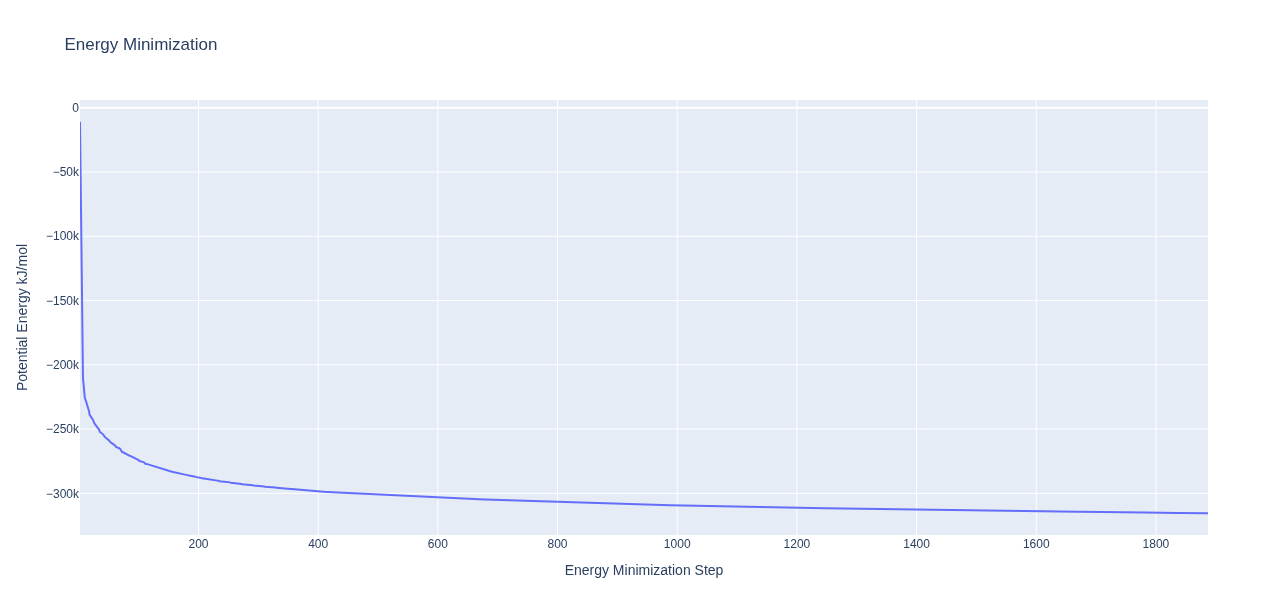

In [31]:
import plotly.graph_objs as go

#Read data from file and filter energy values higher than 1000 kJ/mol
with open(output_min_ene_xvg, 'r') as energy_file:
    x, y = zip(*[
        (float(line.split()[0]), float(line.split()[1]))
        for line in energy_file
        if not line.startswith(("#", "@"))
        if float(line.split()[1]) < 1000
    ])

# Create a scatter plot
fig = go.Figure(data=go.Scatter(x=x, y=y, mode='lines'))

# Update layout
fig.update_layout(title="Energy Minimization",
                  xaxis_title="Energy Minimization Step",
                  yaxis_title="Potential Energy kJ/mol",
                  height=600)

# Show the figure (renderer changes for colab and jupyter)
rend = 'colab' if 'google.colab' in sys.modules else ''
fig.show(renderer=rend)

<a id="nvt"></a>
***
## Equilibrate the system (NVT)
Equilibrate the **protein-ligand complex** system in NVT ensemble (constant Number of particles, Volume and Temperature). To avoid temperature coupling problems, a new *"system"* group will be created including the **protein** + the **ligand** to be assigned to a single thermostatting group.

- [Step 1](#eqNVTStep1): Creating an index file with a new group including the **protein-ligand complex**.
- [Step 2](#eqNVTStep3): Creating portable binary run file for system equilibration
- [Step 3](#eqNVTStep3): Equilibrate the **protein-ligand complex** with NVT ensemble.
- [Step 4](#eqNVTStep4): Checking **NVT Equilibration** results. Plotting **system temperature** by time during the **NVT equilibration** process. 
***
**Building Blocks** used:
- [MakeNdx](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.make_ndx) from **biobb_gromacs.gromacs.make_ndx** 
- [Grompp](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.grompp) from **biobb_gromacs.gromacs.grompp** 
- [Mdrun](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.mdrun) from **biobb_gromacs.gromacs.mdrun** 
- [GMXEnergy](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_energy) from **biobb_analysis.gromacs.gmx_energy** 
***

<a id="eqNVTStep1"></a>
### Step 1: Creating an index file with a new group including the **protein-ligand complex**

In [32]:
# MakeNdx: Creating index file with a new group (protein-ligand complex)
from biobb_gromacs.gromacs.make_ndx import make_ndx

# Create prop dict and inputs/outputs
output_complex_ndx = pdbCode+'_'+ligandCode+'_index.ndx'
prop = {
    'selection': "\"Protein\"|\"Other\"" 
}

# Create and launch bb
make_ndx(input_structure_path=output_min_gro,
        output_ndx_path=output_complex_ndx,
        properties=prop)

2025-10-17 19:25:43,616 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.make_ndx Version: 5.1.0
2025-10-17 19:25:43,617 [MainThread  ] [INFO ]  /home/nikka/GMX_via_biobb/sandbox_51bdcc14-2ffb-4d73-aff6-c488475c93d2 directory successfully created
2025-10-17 19:25:43,618 [MainThread  ] [INFO ]  Copy: pdl1_nctrl_min.gro to /home/nikka/GMX_via_biobb/sandbox_51bdcc14-2ffb-4d73-aff6-c488475c93d2
2025-10-17 19:25:43,619 [MainThread  ] [INFO ]  Copy: /home/nikka/GMX_via_biobb/e8ab7e28-c84e-476d-8419-f60049dcf204.stdin to /home/nikka/GMX_via_biobb/sandbox_51bdcc14-2ffb-4d73-aff6-c488475c93d2
2025-10-17 19:25:43,619 [MainThread  ] [INFO ]  gmx -nobackup -nocopyright make_ndx -f /home/nikka/GMX_via_biobb/sandbox_51bdcc14-2ffb-4d73-aff6-c488475c93d2/pdl1_nctrl_min.gro -o /home/nikka/GMX_via_biobb/sandbox_51bdcc14-2ffb-4d73-aff6-c488475c93d2/pdl1_nctrl_index.ndx < /home/nikka/GMX_via_biobb/sandbox_51bdcc14-2ffb-4d73-aff6-c488475c93d2/e8ab7e28-c84e-476d-8419-f60049dcf204.stdin

2025-10-17 19:2

0

<a id="eqNVTStep2"></a>
### Step 2: Creating portable binary run file for system equilibration (NVT)
Note that for the purposes of temperature coupling, the **protein-ligand complex** (*Protein_Other*) is considered as a single entity.

In [33]:
# Grompp: Creating portable binary run file for NVT System Equilibration
from biobb_gromacs.gromacs.grompp import grompp

# Create prop dict and inputs/outputs
output_gppnvt_tpr = pdbCode+'_'+ligandCode+'gppnvt.tpr'
prop = {
    'mdp':{
        'nsteps':'5000',
        'tc-grps': 'Protein_Other Water_and_ions',
        'Define': '-DPOSRES -D' + posresifdef
    },
    'simulation_type':'nvt'
}

# Create and launch bb
grompp(input_gro_path=output_min_gro,
       input_top_zip_path=output_genion_top_zip,
       input_ndx_path=output_complex_ndx,
       output_tpr_path=output_gppnvt_tpr,
       properties=prop)

2025-10-17 19:25:54,036 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.grompp Version: 5.1.0
2025-10-17 19:25:54,037 [MainThread  ] [INFO ]  /home/nikka/GMX_via_biobb/sandbox_959322c1-fcd3-49ad-ada5-e0e3550dd8b8 directory successfully created
2025-10-17 19:25:54,038 [MainThread  ] [INFO ]  Copy: pdl1_nctrl_min.gro to /home/nikka/GMX_via_biobb/sandbox_959322c1-fcd3-49ad-ada5-e0e3550dd8b8
2025-10-17 19:25:54,039 [MainThread  ] [INFO ]  Copy: pdl1_nctrl_index.ndx to /home/nikka/GMX_via_biobb/sandbox_959322c1-fcd3-49ad-ada5-e0e3550dd8b8
2025-10-17 19:25:54,040 [MainThread  ] [INFO ]  Extracting: /home/nikka/GMX_via_biobb/pdl1_nctrl_genion_top.zip
2025-10-17 19:25:54,041 [MainThread  ] [INFO ]  to:
2025-10-17 19:25:54,041 [MainThread  ] [INFO ]  ['/home/nikka/GMX_via_biobb/sandbox_959322c1-fcd3-49ad-ada5-e0e3550dd8b8/ligand.top', '/home/nikka/GMX_via_biobb/sandbox_959322c1-fcd3-49ad-ada5-e0e3550dd8b8/nctrl_posres.itp', '/home/nikka/GMX_via_biobb/sandbox_959322c1-fcd3-49ad-ada5-e0e355

0

<a id="eqNVTStep3"></a>
### Step 3: Running NVT equilibration

In [34]:
# Mdrun: Running NVT System Equilibration 
from biobb_gromacs.gromacs.mdrun import mdrun

# Create prop dict and inputs/outputs
output_nvt_trr = pdbCode+'_'+ligandCode+'_nvt.trr'
output_nvt_gro = pdbCode+'_'+ligandCode+'_nvt.gro'
output_nvt_edr = pdbCode+'_'+ligandCode+'_nvt.edr'
output_nvt_log = pdbCode+'_'+ligandCode+'_nvt.log'
output_nvt_cpt = pdbCode+'_'+ligandCode+'_nvt.cpt'

# Create and launch bb
mdrun(input_tpr_path=output_gppnvt_tpr,
      output_trr_path=output_nvt_trr,
      output_gro_path=output_nvt_gro,
      output_edr_path=output_nvt_edr,
      output_log_path=output_nvt_log,
      output_cpt_path=output_nvt_cpt)

2025-10-17 19:26:06,133 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.mdrun Version: 5.1.0
2025-10-17 19:26:06,134 [MainThread  ] [INFO ]  /home/nikka/GMX_via_biobb/sandbox_a713303b-6bfc-4dd2-bbf3-060c4f7936c4 directory successfully created
2025-10-17 19:26:06,135 [MainThread  ] [INFO ]  Copy: pdl1_nctrlgppnvt.tpr to /home/nikka/GMX_via_biobb/sandbox_a713303b-6bfc-4dd2-bbf3-060c4f7936c4
2025-10-17 19:26:06,136 [MainThread  ] [INFO ]  gmx -nobackup -nocopyright mdrun -o /home/nikka/GMX_via_biobb/sandbox_a713303b-6bfc-4dd2-bbf3-060c4f7936c4/pdl1_nctrl_nvt.trr -s /home/nikka/GMX_via_biobb/sandbox_a713303b-6bfc-4dd2-bbf3-060c4f7936c4/pdl1_nctrlgppnvt.tpr -c /home/nikka/GMX_via_biobb/sandbox_a713303b-6bfc-4dd2-bbf3-060c4f7936c4/pdl1_nctrl_nvt.gro -e /home/nikka/GMX_via_biobb/sandbox_a713303b-6bfc-4dd2-bbf3-060c4f7936c4/pdl1_nctrl_nvt.edr -g /home/nikka/GMX_via_biobb/sandbox_a713303b-6bfc-4dd2-bbf3-060c4f7936c4/pdl1_nctrl_nvt.log -cpo /home/nikka/GMX_via_biobb/sandbox_a713303b-6bfc-4

0

<a id="eqNVTStep4"></a>
### Step 4: Checking NVT Equilibration results
Checking **NVT Equilibration** results. Plotting **system temperature** by time during the NVT equilibration process. 

In [35]:
# GMXEnergy: Getting system temperature by time during NVT Equilibration  
from biobb_analysis.gromacs.gmx_energy import gmx_energy

# Create prop dict and inputs/outputs
output_nvt_temp_xvg = pdbCode+'_'+ligandCode+'_nvt_temp.xvg'
prop = {
    'terms':  ["Temperature"]
}

# Create and launch bb
gmx_energy(input_energy_path=output_nvt_edr, 
          output_xvg_path=output_nvt_temp_xvg, 
          properties=prop)

2025-10-17 19:26:29,097 [MainThread  ] [INFO ]  Module: biobb_analysis.gromacs.gmx_energy Version: 5.1.0
2025-10-17 19:26:29,098 [MainThread  ] [INFO ]  /home/nikka/GMX_via_biobb/sandbox_06044e48-8009-4aee-a539-646e45ff75ca directory successfully created
2025-10-17 19:26:29,098 [MainThread  ] [INFO ]  Copy: /home/nikka/GMX_via_biobb/pdl1_nctrl_nvt.edr to /home/nikka/GMX_via_biobb/sandbox_06044e48-8009-4aee-a539-646e45ff75ca
2025-10-17 19:26:29,099 [MainThread  ] [INFO ]  gmx energy -f /home/nikka/GMX_via_biobb/sandbox_06044e48-8009-4aee-a539-646e45ff75ca/pdl1_nctrl_nvt.edr -o /home/nikka/GMX_via_biobb/sandbox_06044e48-8009-4aee-a539-646e45ff75ca/pdl1_nctrl_nvt_temp.xvg -xvg none < 6ffcb019-85f1-4f0f-bd50-e5b9e31eb299/instructions.in

2025-10-17 19:26:29,106 [MainThread  ] [INFO ]  Executing: gmx energy -f /home/nikka/GMX_via_biobb/sandbox_06044e48-8009-4aee-a539-646e45ff...
2025-10-17 19:26:29,107 [MainThread  ] [INFO ]  Exit code: 0
2025-10-17 19:26:29,107 [MainThread  ] [INFO ]  
Sta

0

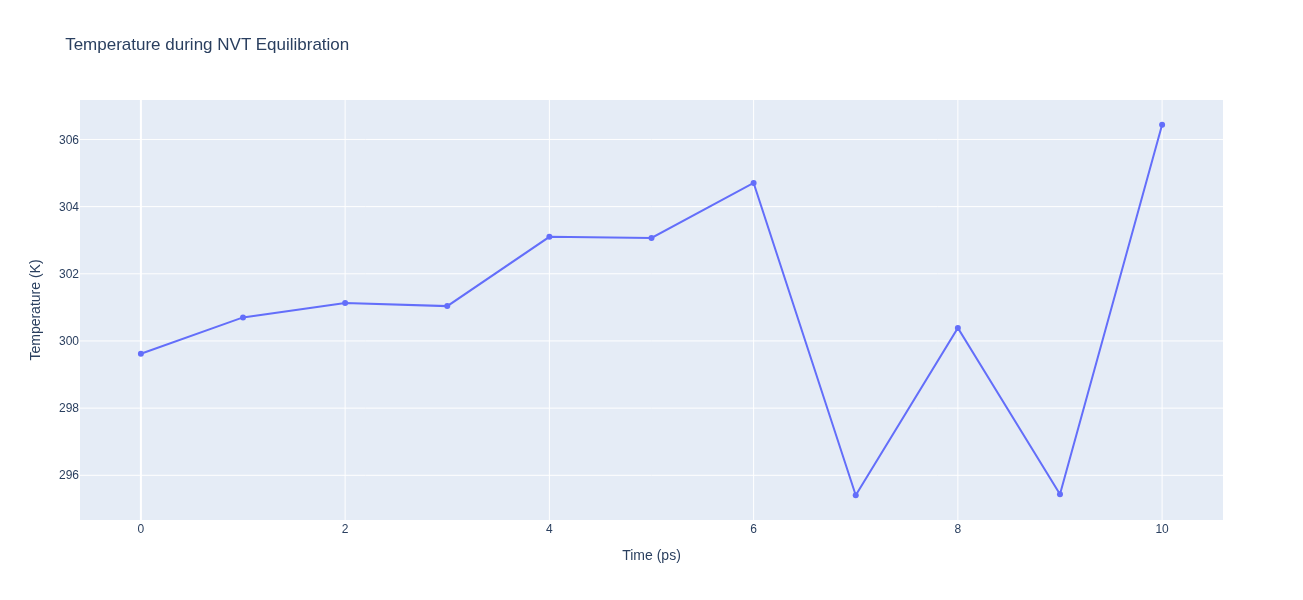

In [36]:
import plotly.graph_objs as go

# Read temperature data from file 
with open(output_nvt_temp_xvg, 'r') as temperature_file:
    x, y = zip(*[
        (float(line.split()[0]), float(line.split()[1]))
        for line in temperature_file
        if not line.startswith(("#", "@"))
    ])

# Create a scatter plot
fig = go.Figure(data=go.Scatter(x=x, y=y, mode='lines+markers'))

# Update layout
fig.update_layout(title="Temperature during NVT Equilibration",
                  xaxis_title="Time (ps)",
                  yaxis_title="Temperature (K)",
                  height=600)

# Show the figure (renderer changes for colab and jupyter)
rend = 'colab' if 'google.colab' in sys.modules else ''
fig.show(renderer=rend)

<a id="npt"></a>
***
## Equilibrate the system (NPT)
Equilibrate the **protein-ligand complex** system in NPT ensemble (constant Number of particles, Pressure and Temperature) .
- [Step 1](#eqNPTStep1): Creating portable binary run file for system equilibration
- [Step 2](#eqNPTStep2): Equilibrate the **protein-ligand complex** with NPT ensemble.
- [Step 3](#eqNPTStep3): Checking **NPT Equilibration** results. Plotting **system pressure and density** by time during the **NPT equilibration** process.
***
**Building Blocks** used:
 - [Grompp](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.grompp) from **biobb_gromacs.gromacs.grompp** 
 - [Mdrun](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.mdrun) from **biobb_gromacs.gromacs.mdrun** 
 - [GMXEnergy](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_energy) from **biobb_analysis.gromacs.gmx_energy** 
***

<a id="eqNPTStep1"></a>
### Step 1: Creating portable binary run file for system equilibration (NPT)

In [37]:
# Grompp: Creating portable binary run file for (NPT) System Equilibration
from biobb_gromacs.gromacs.grompp import grompp

# Create prop dict and inputs/outputs
output_gppnpt_tpr = pdbCode+'_'+ligandCode+'_gppnpt.tpr'
prop = {
    'mdp':{
        'type': 'npt',
        'nsteps':'5000',
        'tc-grps': 'Protein_Other Water_and_ions',
        'Define': '-DPOSRES -D' + posresifdef
    },
    'simulation_type':'npt'
}

# Create and launch bb
grompp(input_gro_path=output_nvt_gro,
       input_top_zip_path=output_genion_top_zip,
       input_ndx_path=output_complex_ndx,
       output_tpr_path=output_gppnpt_tpr,
       input_cpt_path=output_nvt_cpt,
       properties=prop)

2025-10-17 19:26:44,871 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.grompp Version: 5.1.0
2025-10-17 19:26:44,871 [MainThread  ] [INFO ]  /home/nikka/GMX_via_biobb/sandbox_03e27186-4cf8-44ec-ab57-7c8192c076f7 directory successfully created
2025-10-17 19:26:44,873 [MainThread  ] [INFO ]  Copy: pdl1_nctrl_nvt.gro to /home/nikka/GMX_via_biobb/sandbox_03e27186-4cf8-44ec-ab57-7c8192c076f7
2025-10-17 19:26:44,873 [MainThread  ] [INFO ]  Copy: pdl1_nctrl_nvt.cpt to /home/nikka/GMX_via_biobb/sandbox_03e27186-4cf8-44ec-ab57-7c8192c076f7
2025-10-17 19:26:44,874 [MainThread  ] [INFO ]  Copy: pdl1_nctrl_index.ndx to /home/nikka/GMX_via_biobb/sandbox_03e27186-4cf8-44ec-ab57-7c8192c076f7
2025-10-17 19:26:44,875 [MainThread  ] [INFO ]  Extracting: /home/nikka/GMX_via_biobb/pdl1_nctrl_genion_top.zip
2025-10-17 19:26:44,876 [MainThread  ] [INFO ]  to:
2025-10-17 19:26:44,876 [MainThread  ] [INFO ]  ['/home/nikka/GMX_via_biobb/sandbox_03e27186-4cf8-44ec-ab57-7c8192c076f7/ligand.top', '/home/ni

0

<a id="eqNPTStep2"></a>
### Step 2: Running NPT equilibration

In [38]:
# Mdrun: Running NPT System Equilibration
from biobb_gromacs.gromacs.mdrun import mdrun

# Create prop dict and inputs/outputs
output_npt_trr = pdbCode+'_'+ligandCode+'_npt.trr'
output_npt_gro = pdbCode+'_'+ligandCode+'_npt.gro'
output_npt_edr = pdbCode+'_'+ligandCode+'_npt.edr'
output_npt_log = pdbCode+'_'+ligandCode+'_npt.log'
output_npt_cpt = pdbCode+'_'+ligandCode+'_npt.cpt'

# Create and launch bb
mdrun(input_tpr_path=output_gppnpt_tpr,
      output_trr_path=output_npt_trr,
      output_gro_path=output_npt_gro,
      output_edr_path=output_npt_edr,
      output_log_path=output_npt_log,
      output_cpt_path=output_npt_cpt)

2025-10-17 19:26:53,875 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.mdrun Version: 5.1.0
2025-10-17 19:26:53,876 [MainThread  ] [INFO ]  /home/nikka/GMX_via_biobb/sandbox_50cb9b68-a833-494a-8336-629758c438c0 directory successfully created
2025-10-17 19:26:53,877 [MainThread  ] [INFO ]  Copy: pdl1_nctrl_gppnpt.tpr to /home/nikka/GMX_via_biobb/sandbox_50cb9b68-a833-494a-8336-629758c438c0
2025-10-17 19:26:53,878 [MainThread  ] [INFO ]  gmx -nobackup -nocopyright mdrun -o /home/nikka/GMX_via_biobb/sandbox_50cb9b68-a833-494a-8336-629758c438c0/pdl1_nctrl_npt.trr -s /home/nikka/GMX_via_biobb/sandbox_50cb9b68-a833-494a-8336-629758c438c0/pdl1_nctrl_gppnpt.tpr -c /home/nikka/GMX_via_biobb/sandbox_50cb9b68-a833-494a-8336-629758c438c0/pdl1_nctrl_npt.gro -e /home/nikka/GMX_via_biobb/sandbox_50cb9b68-a833-494a-8336-629758c438c0/pdl1_nctrl_npt.edr -g /home/nikka/GMX_via_biobb/sandbox_50cb9b68-a833-494a-8336-629758c438c0/pdl1_nctrl_npt.log -cpo /home/nikka/GMX_via_biobb/sandbox_50cb9b68-a833

0

<a id="eqNPTStep3"></a>
### Step 3: Checking NPT Equilibration results
Checking **NPT Equilibration** results. Plotting **system pressure and density** by time during the **NPT equilibration** process. 

In [39]:
# GMXEnergy: Getting system pressure and density by time during NPT Equilibration  
from biobb_analysis.gromacs.gmx_energy import gmx_energy

# Create prop dict and inputs/outputs
output_npt_pd_xvg = pdbCode+'_'+ligandCode+'_npt_PD.xvg'
prop = {
    'terms':  ["Pressure","Density"]
}

# Create and launch bb
gmx_energy(input_energy_path=output_npt_edr, 
          output_xvg_path=output_npt_pd_xvg, 
          properties=prop)

2025-10-17 19:28:52,568 [MainThread  ] [INFO ]  Module: biobb_analysis.gromacs.gmx_energy Version: 5.1.0
2025-10-17 19:28:52,568 [MainThread  ] [INFO ]  /home/nikka/GMX_via_biobb/sandbox_e76589aa-4918-4a6d-9fa1-b62279cb491a directory successfully created
2025-10-17 19:28:52,569 [MainThread  ] [INFO ]  Copy: /home/nikka/GMX_via_biobb/pdl1_nctrl_npt.edr to /home/nikka/GMX_via_biobb/sandbox_e76589aa-4918-4a6d-9fa1-b62279cb491a
2025-10-17 19:28:52,569 [MainThread  ] [INFO ]  gmx energy -f /home/nikka/GMX_via_biobb/sandbox_e76589aa-4918-4a6d-9fa1-b62279cb491a/pdl1_nctrl_npt.edr -o /home/nikka/GMX_via_biobb/sandbox_e76589aa-4918-4a6d-9fa1-b62279cb491a/pdl1_nctrl_npt_PD.xvg -xvg none < 03e008a0-c4d3-4f67-8508-608d0f3c69aa/instructions.in

2025-10-17 19:28:52,577 [MainThread  ] [INFO ]  Executing: gmx energy -f /home/nikka/GMX_via_biobb/sandbox_e76589aa-4918-4a6d-9fa1-b62279cb...
2025-10-17 19:28:52,578 [MainThread  ] [INFO ]  Exit code: 0
2025-10-17 19:28:52,578 [MainThread  ] [INFO ]  
Stati

0

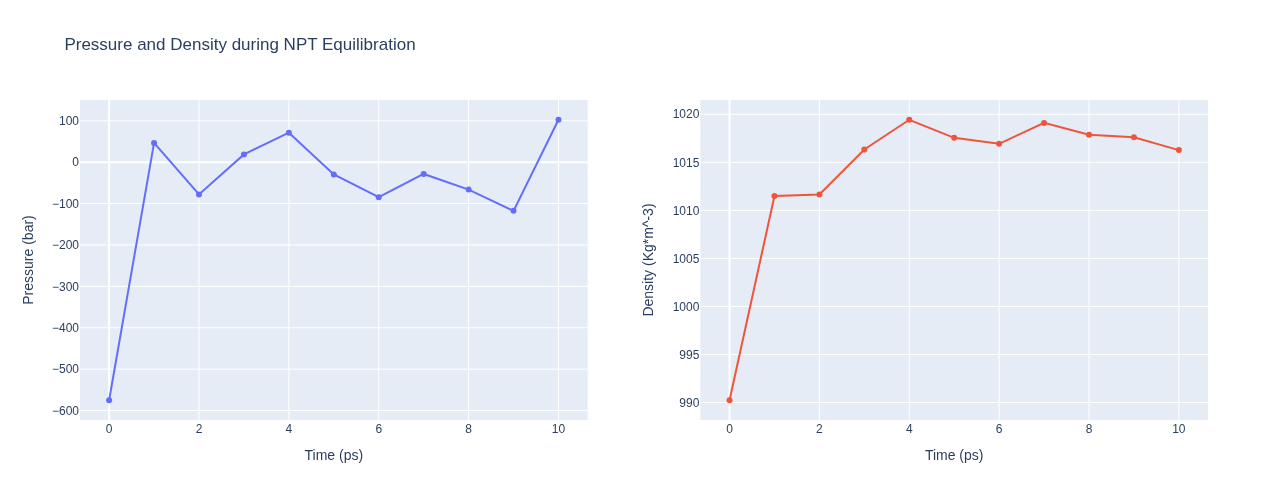

In [38]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Read pressure and density data from file 
with open(output_npt_pd_xvg,'r') as pd_file:
    x, y, z = zip(*[
        (float(line.split()[0]), float(line.split()[1]), float(line.split()[2]))
        for line in pd_file
        if not line.startswith(("#", "@"))
    ])

trace1 = go.Scatter(
    x=x,y=y
)
trace2 = go.Scatter(
    x=x,y=z
)

fig = make_subplots(rows=1, cols=2, print_grid=False)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)

fig.update_layout(
    height=500,
    title='Pressure and Density during NPT Equilibration',
    showlegend=False,
    xaxis1_title='Time (ps)',
    yaxis1_title='Pressure (bar)',
    xaxis2_title='Time (ps)',
    yaxis2_title='Density (Kg*m^-3)'
)

# Show the figure (renderer changes for colab and jupyter)
rend = 'colab' if 'google.colab' in sys.modules else ''
fig.show(renderer=rend)

In [39]:
# MakeNdx: Creating index file with a new group (protein-ligand complex)
from biobb_gromacs.gromacs.make_ndx import make_ndx

# Create prop dict and inputs/outputs
output_complex_ndx = pdbCode+'_'+ligandCode+'_index.ndx'
prop = {
    'selection': "\"Protein\"|\"Other\"" 
}

# Create and launch bb
make_ndx(input_structure_path=output_min_gro,
        output_ndx_path=output_complex_ndx,
        properties=prop)

2025-10-01 21:50:08,442 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.make_ndx Version: 5.1.0
2025-10-01 21:50:08,443 [MainThread  ] [INFO ]  /home/nikka/GMX_via_biobb/sandbox_68b0288f-3258-40d8-be01-b2158404c4ae directory successfully created
2025-10-01 21:50:08,444 [MainThread  ] [INFO ]  Copy: CTLA4_lig10_min.gro to /home/nikka/GMX_via_biobb/sandbox_68b0288f-3258-40d8-be01-b2158404c4ae
2025-10-01 21:50:08,445 [MainThread  ] [INFO ]  Copy: /home/nikka/GMX_via_biobb/f03505aa-cdad-4bbd-833c-b4118a1f83d3.stdin to /home/nikka/GMX_via_biobb/sandbox_68b0288f-3258-40d8-be01-b2158404c4ae
2025-10-01 21:50:08,446 [MainThread  ] [INFO ]  gmx -nobackup -nocopyright make_ndx -f /home/nikka/GMX_via_biobb/sandbox_68b0288f-3258-40d8-be01-b2158404c4ae/CTLA4_lig10_min.gro -o /home/nikka/GMX_via_biobb/sandbox_68b0288f-3258-40d8-be01-b2158404c4ae/CTLA4_lig10_index.ndx < /home/nikka/GMX_via_biobb/sandbox_68b0288f-3258-40d8-be01-b2158404c4ae/f03505aa-cdad-4bbd-833c-b4118a1f83d3.stdin

2025-10-01 2

0

<a id="free"></a>
***
## Free Molecular Dynamics Simulation
Upon completion of the **two equilibration phases (NVT and NPT)**, the system is now well-equilibrated at the desired temperature and pressure. The **position restraints** can now be released. The last step of the **protein-ligand complex** MD setup is a short, **free MD simulation**, to ensure the robustness of the system. 
- [Step 1](#mdStep1): Creating portable binary run file to run a **free MD simulation**.
- [Step 2](#mdStep2): Run short MD simulation of the **protein-ligand complex**.
- [Step 3](#mdStep3): Checking results for the final step of the setup process, the **free MD run**. Plotting **Root Mean Square deviation (RMSd)** and **Radius of Gyration (Rgyr)** by time during the **free MD run** step. 
***
**Building Blocks** used:
 - [Grompp](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.grompp) from **biobb_gromacs.gromacs.grompp** 
 - [Mdrun](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.mdrun) from **biobb_gromacs.gromacs.mdrun** 
 - [GMXRms](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_rms) from **biobb_analysis.gromacs.gmx_rms** 
 - [GMXRgyr](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_rgyr) from **biobb_analysis.gromacs.gmx_rgyr** 
***

### Free MD simulation performed in terminal for gpu-offloading

In [1]:
!gmx --version

                   :-) GROMACS - gmx, 2024.5-conda_forge (-:

Executable:   /home/nikka/miniconda3/envs/biobb/bin.AVX2_256/gmx
Data prefix:  /home/nikka/miniconda3/envs/biobb
Working dir:  /home/nikka/GMX_via_biobb
Command line:
  gmx --version

GROMACS version:     2024.5-conda_forge
Precision:           mixed
Memory model:        64 bit
MPI library:         thread_mpi
OpenMP support:      enabled (GMX_OPENMP_MAX_THREADS = 128)
GPU support:         OpenCL
NBNxM GPU setup:     super-cluster 2x2x2 / cluster 8
SIMD instructions:   AVX2_256
CPU FFT library:     fftw-3.3.10-sse2-avx
GPU FFT library:     clFFT
Multi-GPU FFT:       none
RDTSCP usage:        disabled
TNG support:         enabled
Hwloc support:       disabled
Tracing support:     disabled
C compiler:          /home/conda/feedstock_root/build_artifacts/gromacs_1737879903961/_build_env/bin/x86_64-conda-linux-gnu-cc GNU 13.3.0
C compiler flags:    -fexcess-precision=fast -funroll-all-loops -mavx2 -mfma -Wno-missing-field-initiali

## Replicate runs at different seed velocities
Redo NPT and NVT equilibration at different seed velocities generated randomly.<p>
Restart from NVT step 2 for each replica  <p>
!!Save previous runs in different folders first to avoid overwriting files


In [13]:
#Define input Variables (from step 1 NVT and genion)

pdbCode = 'pdl1'
ligandCode = 'lig10'

posresifdef = "POSRES_"+ligandCode.upper()

output_min_gro = pdbCode+'_'+ligandCode+'_min.gro'  #output_min_gro
output_genion_top_zip = pdbCode+'_'+ligandCode+'_genion_top.zip'   #output_genion_top_zip
output_complex_ndx =  pdbCode+'_'+ligandCode+'_index.ndx' #output_complex_ndx


In [14]:
# Grompp: Creating portable binary run file for NVT System Equilibration
from biobb_gromacs.gromacs.grompp import grompp

# Create prop dict and inputs/outputs
output_gppnvt_tpr = pdbCode+'_'+ligandCode+'gppnvt.tpr'
prop = {
    'mdp':{
        'nsteps':'5000',
        'tc-grps': 'Protein_Other Water_and_ions',
        'Define': '-DPOSRES -D' + posresifdef ,
        'gen_seed' : '-1'
    },
    'simulation_type':'nvt'
}

# Create and launch bb
grompp(input_gro_path=output_min_gro,
       input_top_zip_path=output_genion_top_zip,
       input_ndx_path=output_complex_ndx,
       output_tpr_path=output_gppnvt_tpr,
       properties=prop)

2025-10-10 05:11:25,913 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.grompp Version: 5.1.0
2025-10-10 05:11:25,913 [MainThread  ] [INFO ]  /home/nikka/GMX_via_biobb/PDL1/sandbox_69095ae6-1bba-41c4-963e-4c6ff9b93989 directory successfully created
2025-10-10 05:11:25,914 [MainThread  ] [INFO ]  Copy: pdl1_lig10_min.gro to /home/nikka/GMX_via_biobb/PDL1/sandbox_69095ae6-1bba-41c4-963e-4c6ff9b93989
2025-10-10 05:11:25,915 [MainThread  ] [INFO ]  Copy: pdl1_lig10_index.ndx to /home/nikka/GMX_via_biobb/PDL1/sandbox_69095ae6-1bba-41c4-963e-4c6ff9b93989
2025-10-10 05:11:25,916 [MainThread  ] [INFO ]  Extracting: /home/nikka/GMX_via_biobb/PDL1/pdl1_lig10_genion_top.zip
2025-10-10 05:11:25,917 [MainThread  ] [INFO ]  to:
2025-10-10 05:11:25,917 [MainThread  ] [INFO ]  ['/home/nikka/GMX_via_biobb/PDL1/sandbox_69095ae6-1bba-41c4-963e-4c6ff9b93989/lig10_posres.itp', '/home/nikka/GMX_via_biobb/PDL1/sandbox_69095ae6-1bba-41c4-963e-4c6ff9b93989/lig10params.itp', '/home/nikka/GMX_via_biobb/PDL

0

In [15]:
# Mdrun: Running NVT System Equilibration 
from biobb_gromacs.gromacs.mdrun import mdrun

# Create prop dict and inputs/outputs
output_nvt_trr = pdbCode+'_'+ligandCode+'_nvt.trr'
output_nvt_gro = pdbCode+'_'+ligandCode+'_nvt.gro'
output_nvt_edr = pdbCode+'_'+ligandCode+'_nvt.edr'
output_nvt_log = pdbCode+'_'+ligandCode+'_nvt.log'
output_nvt_cpt = pdbCode+'_'+ligandCode+'_nvt.cpt'

# Create and launch bb
mdrun(input_tpr_path=output_gppnvt_tpr,
      output_trr_path=output_nvt_trr,
      output_gro_path=output_nvt_gro,
      output_edr_path=output_nvt_edr,
      output_log_path=output_nvt_log,
      output_cpt_path=output_nvt_cpt)

2025-10-10 05:11:48,126 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.mdrun Version: 5.1.0
2025-10-10 05:11:48,126 [MainThread  ] [INFO ]  /home/nikka/GMX_via_biobb/PDL1/sandbox_dad30ff2-51f2-4b18-9254-045dae6a11d3 directory successfully created
2025-10-10 05:11:48,128 [MainThread  ] [INFO ]  Copy: pdl1_lig10gppnvt.tpr to /home/nikka/GMX_via_biobb/PDL1/sandbox_dad30ff2-51f2-4b18-9254-045dae6a11d3
2025-10-10 05:11:48,128 [MainThread  ] [INFO ]  gmx -nobackup -nocopyright mdrun -o /home/nikka/GMX_via_biobb/PDL1/sandbox_dad30ff2-51f2-4b18-9254-045dae6a11d3/pdl1_lig10_nvt.trr -s /home/nikka/GMX_via_biobb/PDL1/sandbox_dad30ff2-51f2-4b18-9254-045dae6a11d3/pdl1_lig10gppnvt.tpr -c /home/nikka/GMX_via_biobb/PDL1/sandbox_dad30ff2-51f2-4b18-9254-045dae6a11d3/pdl1_lig10_nvt.gro -e /home/nikka/GMX_via_biobb/PDL1/sandbox_dad30ff2-51f2-4b18-9254-045dae6a11d3/pdl1_lig10_nvt.edr -g /home/nikka/GMX_via_biobb/PDL1/sandbox_dad30ff2-51f2-4b18-9254-045dae6a11d3/pdl1_lig10_nvt.log -cpo /home/nikka/GM

0

### Check NVT Equilibriation results

In [16]:
# GMXEnergy: Getting system temperature by time during NVT Equilibration  
from biobb_analysis.gromacs.gmx_energy import gmx_energy

# Create prop dict and inputs/outputs
output_nvt_temp_xvg = pdbCode+'_'+ligandCode+'_nvt_temp.xvg'
prop = {
    'terms':  ["Temperature"]
}

# Create and launch bb
gmx_energy(input_energy_path=output_nvt_edr, 
          output_xvg_path=output_nvt_temp_xvg, 
          properties=prop)

2025-10-10 05:12:39,185 [MainThread  ] [INFO ]  Module: biobb_analysis.gromacs.gmx_energy Version: 5.1.0
2025-10-10 05:12:39,186 [MainThread  ] [INFO ]  /home/nikka/GMX_via_biobb/PDL1/sandbox_88947929-fe92-46ad-b920-ae32040a1427 directory successfully created
2025-10-10 05:12:39,186 [MainThread  ] [INFO ]  Copy: /home/nikka/GMX_via_biobb/PDL1/pdl1_lig10_nvt.edr to /home/nikka/GMX_via_biobb/PDL1/sandbox_88947929-fe92-46ad-b920-ae32040a1427
2025-10-10 05:12:39,187 [MainThread  ] [INFO ]  gmx energy -f /home/nikka/GMX_via_biobb/PDL1/sandbox_88947929-fe92-46ad-b920-ae32040a1427/pdl1_lig10_nvt.edr -o /home/nikka/GMX_via_biobb/PDL1/sandbox_88947929-fe92-46ad-b920-ae32040a1427/pdl1_lig10_nvt_temp.xvg -xvg none < 025333ff-a1f4-4728-9983-482bddd647a2/instructions.in

2025-10-10 05:12:39,194 [MainThread  ] [INFO ]  Executing: gmx energy -f /home/nikka/GMX_via_biobb/PDL1/sandbox_88947929-fe92-46ad-b920-ae3...
2025-10-10 05:12:39,195 [MainThread  ] [INFO ]  Exit code: 0
2025-10-10 05:12:39,195 [Ma

0

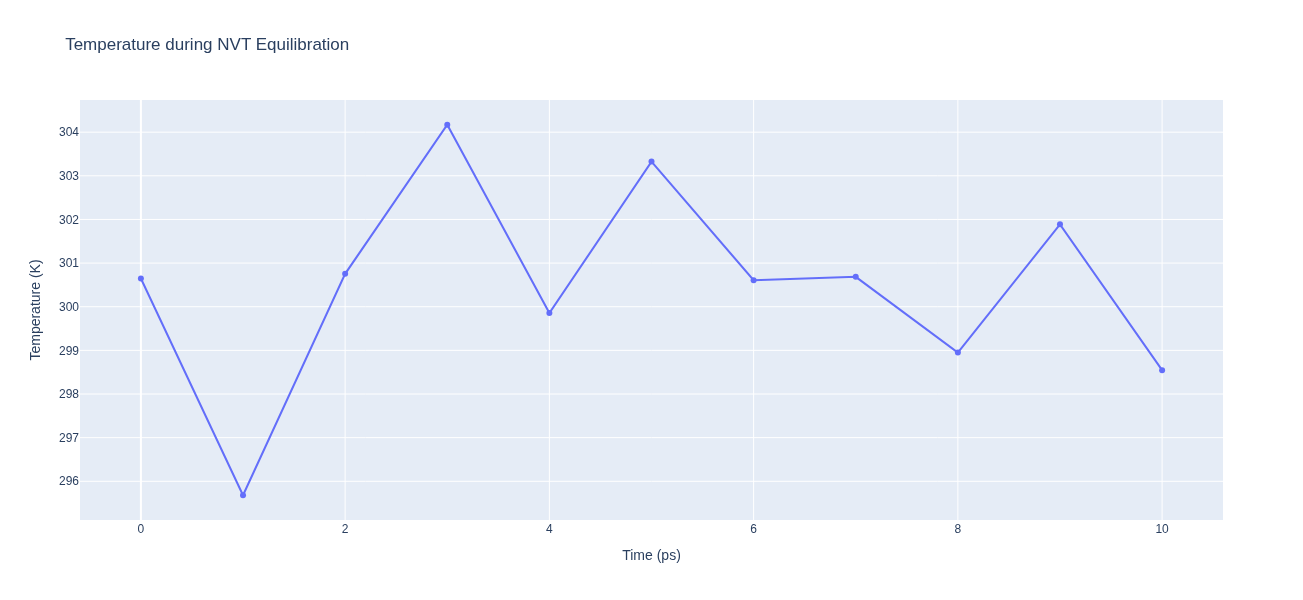

In [17]:
import plotly.graph_objs as go

# Read temperature data from file 
with open(output_nvt_temp_xvg, 'r') as temperature_file:
    x, y = zip(*[
        (float(line.split()[0]), float(line.split()[1]))
        for line in temperature_file
        if not line.startswith(("#", "@"))
    ])

# Create a scatter plot
fig = go.Figure(data=go.Scatter(x=x, y=y, mode='lines+markers'))

# Update layout
fig.update_layout(title="Temperature during NVT Equilibration",
                  xaxis_title="Time (ps)",
                  yaxis_title="Temperature (K)",
                  height=600)

# Show the figure (renderer changes for colab and jupyter)
fig.show()

In [18]:
# Grompp: Creating portable binary run file for (NPT) System Equilibration
from biobb_gromacs.gromacs.grompp import grompp

# Create prop dict and inputs/outputs
output_gppnpt_tpr = pdbCode+'_'+ligandCode+'_gppnpt.tpr'
prop = {
    'mdp':{
        'type': 'npt',
        'nsteps':'5000',
        'tc-grps': 'Protein_Other Water_and_ions',
        'Define': '-DPOSRES -D' + posresifdef
    },
    'simulation_type':'npt'
}

# Create and launch bb
grompp(input_gro_path=output_nvt_gro,
       input_top_zip_path=output_genion_top_zip,
       input_ndx_path=output_complex_ndx,
       output_tpr_path=output_gppnpt_tpr,
       input_cpt_path=output_nvt_cpt,
       properties=prop)

2025-10-10 05:13:19,420 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.grompp Version: 5.1.0
2025-10-10 05:13:19,420 [MainThread  ] [INFO ]  /home/nikka/GMX_via_biobb/PDL1/sandbox_1efb230a-1cad-45dc-a86a-c552e882a438 directory successfully created
2025-10-10 05:13:19,422 [MainThread  ] [INFO ]  Copy: pdl1_lig10_nvt.gro to /home/nikka/GMX_via_biobb/PDL1/sandbox_1efb230a-1cad-45dc-a86a-c552e882a438
2025-10-10 05:13:19,423 [MainThread  ] [INFO ]  Copy: pdl1_lig10_nvt.cpt to /home/nikka/GMX_via_biobb/PDL1/sandbox_1efb230a-1cad-45dc-a86a-c552e882a438
2025-10-10 05:13:19,424 [MainThread  ] [INFO ]  Copy: pdl1_lig10_index.ndx to /home/nikka/GMX_via_biobb/PDL1/sandbox_1efb230a-1cad-45dc-a86a-c552e882a438
2025-10-10 05:13:19,425 [MainThread  ] [INFO ]  Extracting: /home/nikka/GMX_via_biobb/PDL1/pdl1_lig10_genion_top.zip
2025-10-10 05:13:19,426 [MainThread  ] [INFO ]  to:
2025-10-10 05:13:19,426 [MainThread  ] [INFO ]  ['/home/nikka/GMX_via_biobb/PDL1/sandbox_1efb230a-1cad-45dc-a86a-c552e

0

In [19]:
# Mdrun: Running NPT System Equilibration
from biobb_gromacs.gromacs.mdrun import mdrun

# Create prop dict and inputs/outputs
output_npt_trr = pdbCode+'_'+ligandCode+'_npt.trr'
output_npt_gro = pdbCode+'_'+ligandCode+'_npt.gro'
output_npt_edr = pdbCode+'_'+ligandCode+'_npt.edr'
output_npt_log = pdbCode+'_'+ligandCode+'_npt.log'
output_npt_cpt = pdbCode+'_'+ligandCode+'_npt.cpt'

# Create and launch bb
mdrun(input_tpr_path=output_gppnpt_tpr,
      output_trr_path=output_npt_trr,
      output_gro_path=output_npt_gro,
      output_edr_path=output_npt_edr,
      output_log_path=output_npt_log,
      output_cpt_path=output_npt_cpt)

2025-10-10 05:13:23,009 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.mdrun Version: 5.1.0
2025-10-10 05:13:23,010 [MainThread  ] [INFO ]  /home/nikka/GMX_via_biobb/PDL1/sandbox_c39f546e-3cbc-45e9-a450-307d69ee4966 directory successfully created
2025-10-10 05:13:23,011 [MainThread  ] [INFO ]  Copy: pdl1_lig10_gppnpt.tpr to /home/nikka/GMX_via_biobb/PDL1/sandbox_c39f546e-3cbc-45e9-a450-307d69ee4966
2025-10-10 05:13:23,012 [MainThread  ] [INFO ]  gmx -nobackup -nocopyright mdrun -o /home/nikka/GMX_via_biobb/PDL1/sandbox_c39f546e-3cbc-45e9-a450-307d69ee4966/pdl1_lig10_npt.trr -s /home/nikka/GMX_via_biobb/PDL1/sandbox_c39f546e-3cbc-45e9-a450-307d69ee4966/pdl1_lig10_gppnpt.tpr -c /home/nikka/GMX_via_biobb/PDL1/sandbox_c39f546e-3cbc-45e9-a450-307d69ee4966/pdl1_lig10_npt.gro -e /home/nikka/GMX_via_biobb/PDL1/sandbox_c39f546e-3cbc-45e9-a450-307d69ee4966/pdl1_lig10_npt.edr -g /home/nikka/GMX_via_biobb/PDL1/sandbox_c39f546e-3cbc-45e9-a450-307d69ee4966/pdl1_lig10_npt.log -cpo /home/nikka/

0

### Checking NPT Equilibration results

In [20]:
# GMXEnergy: Getting system pressure and density by time during NPT Equilibration  
from biobb_analysis.gromacs.gmx_energy import gmx_energy

# Create prop dict and inputs/outputs
output_npt_pd_xvg = pdbCode+'_'+ligandCode+'_npt_PD.xvg'
prop = {
    'terms':  ["Pressure","Density"]
}

# Create and launch bb
gmx_energy(input_energy_path=output_npt_edr, 
          output_xvg_path=output_npt_pd_xvg, 
          properties=prop)

2025-10-10 05:13:47,455 [MainThread  ] [INFO ]  Module: biobb_analysis.gromacs.gmx_energy Version: 5.1.0
2025-10-10 05:13:47,456 [MainThread  ] [INFO ]  /home/nikka/GMX_via_biobb/PDL1/sandbox_2252c37b-73dd-44a2-8191-2e2f2ed6c49f directory successfully created
2025-10-10 05:13:47,456 [MainThread  ] [INFO ]  Copy: /home/nikka/GMX_via_biobb/PDL1/pdl1_lig10_npt.edr to /home/nikka/GMX_via_biobb/PDL1/sandbox_2252c37b-73dd-44a2-8191-2e2f2ed6c49f
2025-10-10 05:13:47,457 [MainThread  ] [INFO ]  gmx energy -f /home/nikka/GMX_via_biobb/PDL1/sandbox_2252c37b-73dd-44a2-8191-2e2f2ed6c49f/pdl1_lig10_npt.edr -o /home/nikka/GMX_via_biobb/PDL1/sandbox_2252c37b-73dd-44a2-8191-2e2f2ed6c49f/pdl1_lig10_npt_PD.xvg -xvg none < 68e68c35-529e-4442-b0b4-1d586d9631cf/instructions.in

2025-10-10 05:13:47,464 [MainThread  ] [INFO ]  Executing: gmx energy -f /home/nikka/GMX_via_biobb/PDL1/sandbox_2252c37b-73dd-44a2-8191-2e2...
2025-10-10 05:13:47,465 [MainThread  ] [INFO ]  Exit code: 0
2025-10-10 05:13:47,465 [Main

0

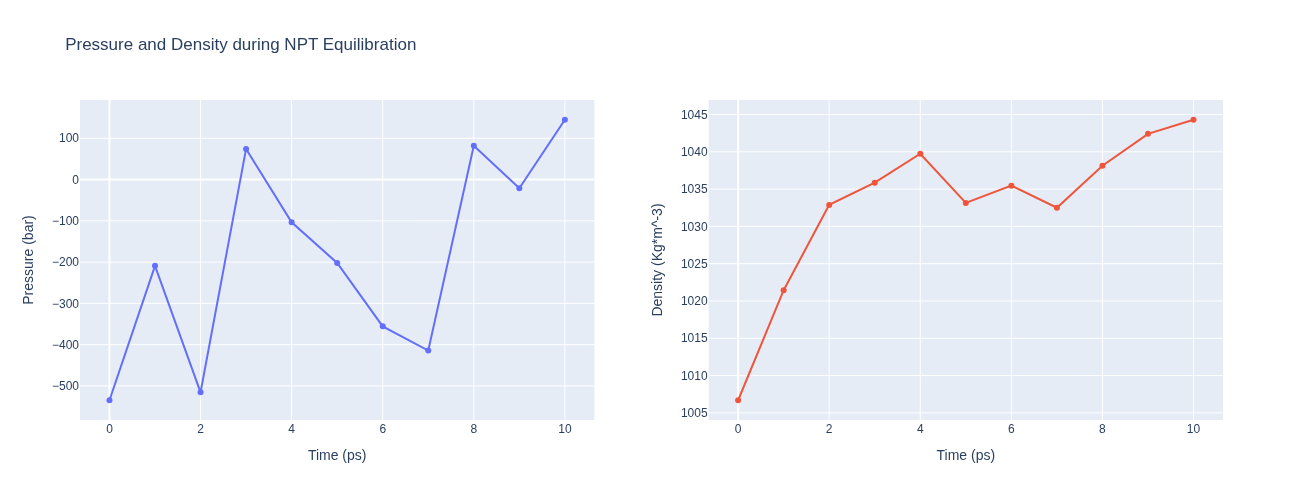

In [21]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Read pressure and density data from file 
with open(output_npt_pd_xvg,'r') as pd_file:
    x, y, z = zip(*[
        (float(line.split()[0]), float(line.split()[1]), float(line.split()[2]))
        for line in pd_file
        if not line.startswith(("#", "@"))
    ])

trace1 = go.Scatter(
    x=x,y=y
)
trace2 = go.Scatter(
    x=x,y=z
)

fig = make_subplots(rows=1, cols=2, print_grid=False)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)

fig.update_layout(
    height=500,
    title='Pressure and Density during NPT Equilibration',
    showlegend=False,
    xaxis1_title='Time (ps)',
    yaxis1_title='Pressure (bar)',
    xaxis2_title='Time (ps)',
    yaxis2_title='Density (Kg*m^-3)'
)

# Show the figure (renderer changes for colab and jupyter)
fig.show()

# Save the new files in a different folder to regenerate a new replica

# Ligand-only solvation (unbound) (For SASA  reference calculation)

In [7]:
# Create box
import subprocess

ligand_str = 'PDL1/lig10_complex_H.pdb'
ligand_top = 'PDL1/a_lig10params.top'
output_editconf = 'PDL1/lig10_box.gro'
wall_dist = '1.0'
box_type = 'octahedron'

'''
commands = """

"""  # customize for your selections
'''
proc = subprocess.run(
    ['gmx', 'editconf', '-f', ligand_str, '-o', output_editconf, '-c', '-d', wall_dist, '-bt', box_type],
    #input=commands.encode(),
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

print(proc.stdout.decode())
print(proc.stderr.decode())

Note that major changes are planned in future for editconf, to improve usability and utility.
Read 41 atoms
Volume: 9138.1 nm^3, corresponds to roughly 4112100 electrons
No velocities found
    system size :  1.028  0.890  1.247 (nm)
    diameter    :  1.347               (nm)
    center      :  2.450 -3.258  2.740 (nm)
    box vectors : 20.564 17.812 24.948 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :9138.10               (nm^3)
    shift       : -0.777  5.624 -1.374 (nm)
new center      :  1.673  2.367  1.366 (nm)
new box vectors :  3.347  3.347  3.347 (nm)
new box angles  :  70.53 109.47  70.53 (degrees)
new box volume  :  28.86               (nm^3)

                     :-) GROMACS - gmx editconf, 2025.3 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/nikka/GMX_via_biobb
Command line:
  gmx editconf -f PDL1/lig10_complex_H.pdb -o PDL1/lig10_box.gro -c -d 1.0 -bt octahedron


GROMACS reminds you: "Jede der

In [8]:
# Solvate box
import subprocess

ligand_top = 'PDL1/a_lig10params.top'
input_editconf = 'PDL1/lig10_box.gro'
output_solv = 'PDL1/lig10_solv.gro'

'''
commands = """

"""  # customize for your selections
'''
proc = subprocess.run(
    ['gmx', 'solvate', '-cp', input_editconf, '-cs', 'spc216.gro', '-o', output_solv, '-p', ligand_top],
    #input=commands.encode(),
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

print(proc.stdout.decode())
print(proc.stderr.decode())


         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.

NOTE: From version 5.0 gmx solvate uses the Van der Waals radii
from the source below. This means the results may be different
compared to previous GROMACS versions.

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
A. Bondi
van der Waals Volumes and Radii
J. Phys. Chem. (1964)
DOI: 10.1021/j100785a001
-------- -------- --- Thank You --- -------- --------

Adding line for 914 solvent molecules with resname (SOL) to topology file (PDL1/a_lig10params.top)

                     :-) GROMACS - gmx solvate, 2025.3 (-:

Executable:   /usr/local/gromacs/

In [8]:
# Solvate box
import subprocess

ligand_top = 'PDL1/a_lig10params.top'
input_editconf = 'PDL1/lig10_box.gro'
output_solv = 'PDL1/lig10_solv.gro'

'''
commands = """

"""  # customize for your selections
'''
proc = subprocess.run(
    ['gmx', 'solvate', '-cp', input_editconf, '-cs', 'spc216.gro', '-o', output_solv, '-p', ligand_top],
    #input=commands.encode(),
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

print(proc.stdout.decode())
print(proc.stderr.decode())


         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.

NOTE: From version 5.0 gmx solvate uses the Van der Waals radii
from the source below. This means the results may be different
compared to previous GROMACS versions.

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
A. Bondi
van der Waals Volumes and Radii
J. Phys. Chem. (1964)
DOI: 10.1021/j100785a001
-------- -------- --- Thank You --- -------- --------

Adding line for 914 solvent molecules with resname (SOL) to topology file (PDL1/a_lig10params.top)

                     :-) GROMACS - gmx solvate, 2025.3 (-:

Executable:   /usr/local/gromacs/

In [14]:
# Prepare for addition of ions
import subprocess

mdp_ion = 'PDL1/ions.mdp'
ligand_top = 'PDL1/a_lig10params.top'
input_solv = 'PDL1/lig10_solv.gro'
ion_tpr = 'PDL1/lig10_ions.tpr'

'''
commands = """

"""  # customize for your selections
'''
proc = subprocess.run(
    ['gmx', 'grompp', '-f', mdp_ion, '-c', input_solv, '-p', ligand_top, '-o', ion_tpr],
    #input=commands.encode(),
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

print(proc.stdout.decode())
print(proc.stderr.decode())

Setting the LD random seed to 2078241785

Generated 2926 of the 2926 non-bonded parameter combinations

Generated 2926 of the 2926 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'lig10params'

Excluding 2 bonded neighbours molecule type 'SOL'
Analysing residue names:
There are:     1      Other residues
There are:   914      Water residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

This run will generate roughly 0 Mb of data

                      :-) GROMACS - gmx grompp, 2025.3 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/nikka/GMX_via_biobb
Command line:
  gmx grompp -f PDL1/ions.mdp -c PDL1/lig10_solv.gro -p PDL1/a_lig10params.top -o PDL1/lig10_ions.tpr

Generating 1-4 interactions: fudge = 0.5
Number of degrees of freedom in T-Coupling group rest is 5604.00
The integrator does not provide a ensemble temperature, there is no system ensemble temperature

NOTE 

In [20]:
# Add ions
import subprocess

ligand_top = 'PDL1/a_lig10params.top'
ion_tpr = 'PDL1/lig10_ions.tpr'
output_ion = 'PDL1/lig10_ions.gro'
ion_conc = '0.15'


commands = """
4
"""  # customize for your selections

proc = subprocess.run(
    ['gmx', 'genion', '-s', ion_tpr, '-o', output_ion, '-p', ligand_top, '-pname', 'NA', '-nname', 'CL', '-neutral', '-conc', ion_conc],
    input=commands.encode(),
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

print(proc.stdout.decode())
print(proc.stderr.decode())

Will try to add 3 NA ions and 3 CL ions.
Select a continuous group of solvent molecules
Selected 4: 'SOL'

Processing topology
Replacing 6 solute molecules in topology file (PDL1/a_lig10params.top)  by 3 NA and 3 CL ions.

                      :-) GROMACS - gmx genion, 2025.3 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/nikka/GMX_via_biobb
Command line:
  gmx genion -s PDL1/lig10_ions.tpr -o PDL1/lig10_ions.gro -p PDL1/a_lig10params.top -pname NA -nname CL -neutral -conc 0.15

Reading file PDL1/lig10_ions.tpr, VERSION 2025.3 (single precision)
Reading file PDL1/lig10_ions.tpr, VERSION 2025.3 (single precision)
Group     0 (         System) has  2783 elements
Group     1 (          Other) has    41 elements
Group     2 (            UNL) has    41 elements
Group     3 (          Water) has  2742 elements
Group     4 (            SOL) has  2742 elements
Group     5 (      non-Water) has    41 elements
Select a group: Number of (3-atom

In [22]:
# Prepare for energy minimization
import subprocess

mdp_em = 'PDL1/em.mdp'
ligand_top = 'PDL1/a_lig10params.top'
input_ion = 'PDL1/lig10_ions.gro'
em_tpr = 'PDL1/lig10_em.tpr'

'''
commands = """

"""  # customize for your selections
'''
proc = subprocess.run(
    ['gmx', 'grompp', '-f', mdp_em, '-c', input_ion, '-p', ligand_top, '-o', em_tpr],

    #input=commands.encode(),
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

print(proc.stdout.decode())
print(proc.stderr.decode())

Setting the LD random seed to 1843920365

Generated 2926 of the 2926 non-bonded parameter combinations

Generated 2926 of the 2926 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'lig10params'

Excluding 2 bonded neighbours molecule type 'SOL'

Excluding 1 bonded neighbours molecule type 'NA'

Excluding 1 bonded neighbours molecule type 'CL'
Analysing residue names:
There are:     1      Other residues
There are:   908      Water residues
There are:     6        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

The largest distance between excluded atoms is 0.396 nm between atom 23 and 33
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 28x28x28, spacing 0.120 0.120 0.120

Estimate for the relative computational load of the PME mesh part: 0.25

This run will generate roughly 2 Mb of data

                      :-) GROMACS - gmx grompp, 2025.3 (-:

Executable:   /usr/local/gromacs/bin/gmx
Da

In [24]:
# Run energy minimization
import subprocess


EMname = 'PDL1/lig10_em'

'''
commands = """

"""  # customize for your selections
'''
proc = subprocess.run(
    ['gmx', 'mdrun', '-deffnm', EMname],

    #input=commands.encode(),
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

print(proc.stdout.decode())
print(proc.stderr.decode())


                      :-) GROMACS - gmx mdrun, 2025.3 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/nikka/GMX_via_biobb
Command line:
  gmx mdrun -deffnm PDL1/lig10_em

Reading file PDL1/lig10_em.tpr, VERSION 2025.3 (single precision)
1 GPU selected for this run.
Mapping of GPU IDs to the 1 GPU task in the 1 rank on this node:
  PP:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the CPU
Using 1 MPI thread
Using 12 OpenMP threads 


Steepest Descents:
   Tolerance (Fmax)   =  1.00000e+03
   Number of steps    =        50000

writing lowest energy coordinates.

Steepest Descents converged to Fmax < 1000 in 236 steps
Potential Energy  = -3.7179043e+04
Maximum force     =  7.9190222e+02 on atom 3
Norm of force     =  7.1133070e+01

GROMACS reminds you: "Physics is like sex: sure, it may give some practical results, but that's not why we do it" (Richard P. Feynman)


In [26]:
# Run energy minimization
import subprocess


input_gro = 'PDL1/lig10_em.gro'
input_tpr = 'PDL1/lig10_em.tpr'
output_xvg = 'PDL1/lig10_sasa.xvg'

commands = """
2
"""  # customize for your selections

proc = subprocess.run(
    ['gmx', 'sasa', '-f', input_gro, '-s', input_tpr, '-o', output_xvg],

    input=commands.encode(),
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

print(proc.stdout.decode())
print(proc.stderr.decode())


         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.

NOTE: From version 5.0 gmx sasa uses the Van der Waals radii
from the source below. This means the results may be different
compared to previous GROMACS versions.

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
A. Bondi
van der Waals Volumes and Radii
J. Phys. Chem. (1964)
DOI: 10.1021/j100785a001
-------- -------- --- Thank You --- -------- --------


                       :-) GROMACS - gmx sasa, 2025.3 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/nikka/GMX_via_biobb
Command line:
  gmx sa

                       :-) GROMACS - gmx sasa, 2025.3 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/nikka/GMX_via_biobb
Command line:
  gmx sasa -f PDL1/lig10_em.gro -s PDL1/lig10_em.tpr -o sasa_lig10.xvg

Reading file PDL1/lig10_em.tpr, VERSION 2025.3 (single precision)
Reading file PDL1/lig10_em.tpr, VERSION 2025.3 (single precision)
Available static index groups:
 Group  0 "System" (2771 atoms)
 Group  1 "Other" (41 atoms)
 Group  2 "UNL" (41 atoms)
 Group  3 "NA" (3 atoms)
 Group  4 "CL" (3 atoms)
 Group  5 "Water" (2724 atoms)
 Group  6 "SOL" (2724 atoms)
 Group  7 "non-Water" (47 atoms)
 Group  8 "Ion" (6 atoms)
 Group  9 "Water_and_ions" (2730 atoms)
Specify a selection for option 'surface'
(Surface calculation selection):
(one per line, <enter> for status/groups, 'help' for help)
> ^C
